In [1]:
import numpy as np

class Environment:
    def __init__(self, initial_state, xd=10, dt=0.01):
        """
        Initializes the environment with a specified initial state, desired trajectory (xd), and time step.
        Args:
        initial_state : list or array-like - Initial state vector [e, dot_e]
        xd : float - Desired trajectory, changes during the simulation from 10 to -10
        dt : float - Time step for the simulation
        """
        # System matrices based on the given dynamics in the converted MATLAB code
        M = 6  # Mass of the system
        C = -0.2  # Damping coefficient
        self.A = np.array([[0, 1],
                           [0, -C / M]], dtype=np.float32)
        self.B1 = np.array([[0],
                            [1 / M]], dtype=np.float32)  # Robot's input
        self.B2 = self.B1.copy()  # Assuming human and robot share similar dynamics

        self.xd = xd  # Desired trajectory
        self.initial_state = np.array(initial_state, dtype=np.float32).reshape(-1, 1)
        self.current_state = self.initial_state.copy()
        self.dt = dt

    def reset(self):
        """
        Resets the environment to the initial state.
        """
        self.current_state = self.initial_state.copy()
        return self.current_state

    def flip_xd(self):
        """
        Flips the desired trajectory (xd) between positive and negative values.
        """
        self.current_state[0] = self.current_state[0] + self.xd
        self.xd = -self.xd
        self.current_state[0] = self.current_state[0] - self.xd
        #self.current_state[1] = 0

    def next_state(self, u1, u2):
        """
        Computes and updates the environment's current state using given control inputs.
        Args:
        u1 : np.ndarray - Control input vector from agent 1 (human)
        u2 : np.ndarray - Control input vector from agent 2 (robot)
        Returns:
        x_next : np.ndarray - Next state vector (column)
        """
        x_current = self.current_state.copy()
        self.current_state = self.predict_next_state(x_current, u1, u2)
        return self.current_state

    def predict_next_state(self, state, u1, u2):
        """
        Predicts the next state given the current state and control inputs, without updating the environment's state.
        Args:
        state : np.ndarray - Current state from which to predict the next state
        u1 : np.ndarray - Control input vector from agent 1 (human)
        u2 : np.ndarray - Control input vector from agent 2 (robot)
        Returns:
        x_next : np.ndarray - Predicted next state vector (column)
        """
        # Ensure control inputs are column vectors
        u1 = np.array(u1).reshape(-1, 1)
        u2 = np.array(u2).reshape(-1, 1)

        # Compute the rate of change of the state
        x_dot = self.A @ state + self.B1 @ u1 + self.B2 @ u2

        # Integrate to find the next state
        x_next = state + self.dt * x_dot

        # Return the next state as a column vector
        return x_next

# Example usage:
env = Environment([0.0, 0.0], xd=10, dt=0.01)  # Initial state and xd
state = env.reset()
print("Initial state (column vector):\n", state)

# Example of control inputs and state update
next_state = env.next_state(np.array([1.0]), np.array([0.8]))  # Control inputs u1 and u2 as 1D vectors
print("Next state (column vector):\n", next_state)

# Flipping xd in the middle of the simulation
env.flip_xd()
print(f"New desired trajectory (xd): {env.xd}")


Initial state (column vector):
 [[0.]
 [0.]]
Next state (column vector):
 [[0.   ]
 [0.003]]
New desired trajectory (xd): -10


In [2]:
import numpy as np
from scipy.linalg import solve_continuous_are, solve_continuous_lyapunov

class Agent:
    def __init__(self, A, B, Q, other_agent_B, other_agent_K_init, dt=0.01, learning_rate=0.1, history_size=15):
        """
        Initializes the agent with system matrices, cost matrices, and learning rate for simple gradient descent.
        """
        self.A = A
        self.B = B
        self.Q = Q
        self.R = np.eye(1)  # Identity matrix for R
        self.other_agent_B = other_agent_B
        self.other_agent_K = other_agent_K_init
        self.u_other = 0

        self.dt = dt
        self.P = np.eye(A.shape[0])  # Initialize the Riccati matrix P
        self.K = None
        self.history_size = history_size
        self.state_history = []
        self.K_history = []
        self.u_other_history = []

        # Initialize theta_other as a vector (one for each diagonal element of Q)
        self.theta_other = np.random.uniform(0.0001, 0.00011, size=(A.shape[0],))  # Initial guess for theta_other as a vector
        self.P_other = np.eye(A.shape[0])  # Initial Riccati matrix for the other agent
        self.learning_rate = learning_rate
        self.total_cost = 0

    def solve_riccati(self):
        """
        Solves the Riccati equation for the agent's control gain K based on the current estimate of the other agent's gain.
        """
        A_eff = self.A - self.other_agent_B @ self.other_agent_K  # Adjusted A matrix considering other agent's gain

        try:
            P = solve_continuous_are(A_eff, self.B, self.Q, self.R)  # Simplified since R = I
            self.P = P
            self.K = self.B.T @ P  # No need for inv(R), because R = I
        except np.linalg.LinAlgError:
            print("Error in solving Riccati equation")
            self.P = np.eye(self.A.shape[0]) * 0.01
            self.K = np.zeros((self.B.shape[1], self.A.shape[0]))

    def estimate_P_other(self, current_K):
        """
        Solves the Riccati equation for the other agent to estimate P_other based on theta_other.
        The Riccati equation for the other agent uses the current K of this agent.
        """
        # Create a diagonal Q_other matrix based on the current theta_other vector
        Q_other = np.diag(self.theta_other)

        A_eff_other = self.A - self.B @ current_K  # The other agent assumes they know our current K
        try:
            P_other = solve_continuous_are(A_eff_other, self.other_agent_B, Q_other, self.R)  # R = I
            self.P_other = P_other
            self.other_agent_K = self.other_agent_B.T @ P_other  # No inv(R), since R = I
        except np.linalg.LinAlgError:
            print("Error in solving Riccati equation for other agent")
            self.P_other = np.eye(self.A.shape[0]) * 0.01
            self.other_agent_K = np.zeros((self.other_agent_B.shape[1], self.A.shape[0]))

    def compute_dP_other_dtheta(self, current_K, i):
        """
        Computes dP_other/dtheta_i by solving the Lyapunov equation derived from the Riccati equation for the i-th theta.
        """
        # Define A_eff_other = A - BK_current
        A_eff_other = self.A - self.B @ current_K

        # Create a matrix with 1 at the i-th diagonal position and 0 elsewhere
        C_i = np.zeros_like(self.A)
        C_i[i, i] = 1  # This replaces the identity matrix in the Lyapunov equation

        # Define A_lya based on A_eff_other and P_other
        A_lya = A_eff_other - self.other_agent_B @ self.other_agent_B.T @ self.P_other

        # Solve the Lyapunov equation A_lya^T dP_other/dtheta + dP_other_dtheta A_lya + C_i = 0
        dP_other_dtheta_i = solve_continuous_lyapunov(A_lya.T, C_i)  # C_i replaces the identity matrix
        return dP_other_dtheta_i

    def get_control_input(self, state):
        """
        Computes the control input given the current state.
        Uses the gain matrix K derived from the Riccati equation solution.
        """
        if self.K is None:
            raise ValueError("K matrix has not been computed. Call solve_riccati() first.")
        
        # Control signal: u = -K * state
        noise = 0 * np.random.rand()
        self.u_other = -self.other_agent_K @ state
        control_signal = -self.K @ state + noise
        self.total_cost = self.total_cost + control_signal.T@control_signal + state.T@self.Q@state
        return control_signal

    def update_state_history(self, state, u_other):
        """
        Updates the state history with the latest state and the control input of the other agent.
        Also keeps track of the agent's gain K.
        """
        if len(self.state_history) > self.history_size:
            self.state_history.pop(0)
            self.u_other_history.pop(0)
            self.K_history.pop(0)

        self.state_history.append(state)
        self.u_other_history.append(u_other)
        self.K_history.append(self.K)
        
    def reset_history(self):
        self.state_history = []
        self.K_history = []
        self.u_other_history = []
        self.total_cost = 0

    def simulate_trajectory_and_compute_error(self):
        """
        Simulates a trajectory using the current estimated theta_other and computes the state errors with derivatives.
        """
        gradients = np.zeros_like(self.theta_other)  # Initialize gradients for each theta element
        errors = []

        # Initial observed state from the history for trajectory simulation
        estimated_state = self.state_history[0].copy()
        
        # Initialize d_error_dtheta as a list of vectors for each theta parameter
        d_error_dtheta = [np.zeros_like(estimated_state) for _ in range(len(self.theta_other))]

        for i in range(1, len(self.state_history)):
            # Estimate P_other at each step based on the current K in history
            current_K = self.K_history[i - 1]
            self.estimate_P_other(current_K)
            u_other_predict = -self.other_agent_B.T @ self.P_other @ self.state_history[i-1]

            # State derivative and next estimated state based on predicted u_other
            state_dot = self.A @ estimated_state + self.B @ (-current_K @ self.state_history[i-1]) + self.other_agent_B @ u_other_predict
            estimated_state = estimated_state + self.dt * state_dot

            # Calculate the error with the observed state
            error = self.state_history[i] - estimated_state
            errors.append(error)

            # Update d_error_dtheta for each theta parameter
            for j in range(len(self.theta_other)):
                dP_other_dtheta_j = self.compute_dP_other_dtheta(current_K, j)
                d_u_other_predict_dtheta_j = -self.other_agent_B.T @ dP_other_dtheta_j @ self.state_history[i-1] #-self.other_agent_B.T@self.P_other@d_error_dtheta[j]
                d_error_dot_dtheta_j = self.A @ d_error_dtheta[j] + self.other_agent_B @ d_u_other_predict_dtheta_j
                d_error_dtheta[j] = d_error_dtheta[j] + self.dt * d_error_dot_dtheta_j

                # Accumulate gradients for each theta
                gradients[j] += 100*error.T @ d_error_dtheta[j]

        return np.array(errors), gradients

    def recompute_error_history(self):
        """
        Calculates the gradients based on the simulated trajectory error.
        """
        _, gradients = self.simulate_trajectory_and_compute_error()
        return gradients

    def gradient_descent_update(self):
        """
        Updates theta_other using simple gradient descent based on the computed trajectory errors.
        """
        gradients = self.recompute_error_history()
        
        # Simple Gradient Descent update
        self.theta_other -= self.learning_rate * gradients
        self.theta_other = np.maximum(self.theta_other, 1e-6)  # Preventing negative values

        # Recompute P_other with the updated theta_other
        self.estimate_P_other(self.K)


[0.00010385 0.00010754]
[0.00010397 0.00010754]
[0.00010456 0.00010753]
[0.00010616 0.0001075 ]
[0.00010953 0.0001074 ]
[0.00011556 0.00010716]
[0.00012531 0.00010669]
[0.00013999 0.00010584]
[0.0001609  0.00010445]
[0.00018949 0.00010229]
[2.27268367e-04 9.91119301e-05]
[2.75848541e-04 9.46027483e-05]
[3.36914078e-04 8.84153147e-05]
[4.12212605e-04 8.01541041e-05]
[5.03546778e-04 6.93779653e-05]
[6.12765756e-04 5.56005290e-05]
[7.15154361e-04 4.01416356e-05]
[8.11078548e-04 2.33032415e-05]
[9.00885151e-04 5.35879539e-06]
[9.84902898e-04 1.00000000e-06]
[1.06344337e-03 1.00000000e-06]
[1.13680192e-03 1.00000000e-06]
[1.2052585e-03 1.0000000e-06]
[1.26907849e-03 1.00000000e-06]
[1.32851348e-03 1.00000000e-06]
[1.38380196e-03 1.00000000e-06]
[1.43517005e-03 1.00000000e-06]
[1.48283209e-03 1.00000000e-06]
[1.52699133e-03 1.00000000e-06]
[1.56784043e-03 1.00000000e-06]
[1.60556208e-03 1.00000000e-06]
[1.64032949e-03 1.00000000e-06]
[1.67230686e-03 1.00000000e-06]
[1.70164991e-03 1.00000000

[19.37205809 23.90468776]
[19.18107361 24.19704855]
[18.99362686 24.48618236]
[18.80966629 24.77209226]
[18.62914047 25.0547828 ]
[18.45199816 25.33425986]
[18.27818834 25.61053059]
[18.10766026 25.88360335]
[17.94036347 26.15348763]
[17.77624783 26.42019396]
[17.61526357 26.68373388]
[17.45736132 26.94411987]
[17.30249209 27.20136527]
[17.15060732 27.45548426]
[17.0016589  27.70649182]
[16.85559919 27.9544036 ]
[16.712381   28.19923599]
[16.57195766 28.441006  ]
[16.43428296 28.67973122]
[16.29931123 28.91542982]
[16.16699731 29.14812051]
[16.03729655 29.37782247]
[15.91016484 29.60455533]
[15.7855586  29.82833917]
[15.66343479 30.04919447]
[15.54375091 30.26714205]
[15.42646501 30.48220312]
[15.31153567 30.69439916]
[15.19892203 30.90375198]
[15.08858375 31.11028365]
[14.98048108 31.31401651]
[14.87457476 31.5149731 ]
[14.77082612 31.7131762 ]
[14.66919699 31.90864877]
[14.56964976 32.10141395]
[14.47214737 32.29149505]
[14.37665325 32.47891551]
[14.2831314  32.66369891]
[14.19154632

[62.54319038 46.36318643]
[62.98952992 46.31838935]
[63.40053905 46.26954596]
[63.77845667 46.2176665 ]
[64.12558242 46.16362462]
[64.4442775  46.10815305]
[64.73695691 46.05184092]
[65.00607326 45.99513363]
[65.25387324 45.93838557]
[65.48237275 45.8818819 ]
[65.69337378 45.82585163]
[65.88848662 45.77047759]
[66.06915043 45.7159047 ]
[66.23665158 45.6622471 ]
[66.39213979 45.60959405]
[66.53664269 45.55801504]
[66.67107876 45.50756401]
[66.79626906 45.45828281]
[66.91294789 45.41020409]
[67.02177244 45.36335352]
[67.1233316  45.31775157]
[67.21815394 45.2734148 ]
[67.306715   45.23035678]
[67.38944388 45.18858866]
[67.46672916 45.14811954]
[67.53892406 45.10895662]
[67.60635081 45.07110536]
[67.66930442 45.0345696 ]
[67.72805591 44.9993516 ]
[67.78285502 44.96545215]
[67.83393265 44.93287057]
[67.88150286 44.90160475]
[67.92576469 44.87165123]
[67.96690363 44.84300519]
[68.00509303 44.81566049]
[68.04049519 44.78960974]
[68.07326242 44.76484431]
[68.10353791 44.74135438]
[68.1314565 

[71.88355354 46.20424628]
[71.88159387 46.21128754]
[71.87968129 46.21831998]
[71.87781603 46.22534083]
[71.87599824 46.23234743]
[71.87422805 46.23933719]
[71.8725055  46.24630761]
[71.87083062 46.25325626]
[71.86920334 46.26018082]
[71.8676236  46.26707901]
[71.86609125 46.27394866]
[71.86460612 46.28078767]
[71.863168 46.287594]
[71.86177664 46.29436571]
[71.86043175 46.30110093]
[71.85913302 46.30779783]
[71.8578801 46.3144547]
[71.85667261 46.32106986]
[71.85551014 46.32764173]
[71.85439226 46.33416878]
[71.85331852 46.34064955]
[71.85228842 46.34708264]
[71.85130149 46.35346672]
[71.85035718 46.35980053]
[71.84945496 46.36608285]
[71.84859429 46.37231255]
[71.84777457 46.37848853]
[71.84699524 46.38460977]
[71.84625568 46.39067528]
[71.84555529 46.39668416]
[71.84489344 46.40263553]
[71.84426951 46.40852859]
[71.84368284 46.41436257]
[71.84313278 46.42013676]
[71.84261869 46.42585051]
[71.84213989 46.4315032 ]
[71.84169572 46.43709426]
[71.8412855  46.44262317]
[71.84090856 46.44

[73.57917238 47.2871392 ]
[73.57889014 47.28733144]
[73.57833821 47.28770658]
[73.57753127 47.28826503]
[73.57648346 47.28900683]
[73.57520846 47.28993162]
[73.57371944 47.29103871]
[73.57202913 47.29232707]
[73.57014979 47.29379537]
[73.56809322 47.29544203]
[73.56587081 47.29726516]
[73.5634935  47.29926266]
[73.56097184 47.30143221]
[73.55831595 47.30377125]
[73.55553559 47.30627707]
[73.5526401  47.30894677]
[73.54963847 47.31177728]
[73.54653933 47.31476541]
[73.54335095 47.31790783]
[73.54008127 47.3212011 ]
[73.53673788 47.32464166]
[73.53332806 47.32822588]
[73.52985878 47.33195004]
[73.5263367  47.33581034]
[73.52276819 47.33980295]
[73.51915933 47.34392396]
[73.51551593 47.34816944]
[73.51184353 47.35253542]
[73.50814742 47.35701791]
[73.50443261 47.3616129 ]
[73.50070391 47.36631637]
[73.49696587 47.3711243 ]
[73.49322282 47.37603267]
[73.48947886 47.38103749]
[73.4857379  47.38613476]
[73.48200364 47.39132051]
[73.47827957 47.3965908 ]
[73.474569  47.4019417]
[73.47087506 4

[73.74306519 48.38365798]
[73.74287077 48.38658052]
[73.74269415 48.38946139]
[73.74253487 48.39230072]
[73.74239248 48.39509868]
[73.74226652 48.3978554 ]
[73.74215654 48.40057106]
[73.74206209 48.40324585]
[73.74198275 48.40587995]
[73.74191807 48.40847358]
[73.74186763 48.41102694]
[73.74183101 48.41354026]
[73.7418078  48.41601377]
[73.74179758 48.41844772]
[73.74179994 48.42084236]
[73.7418145  48.42319796]
[73.74184086 48.42551477]
[73.74187864 48.42779309]
[73.74192744 48.4300332 ]
[73.74192744 48.4300332 ]
[73.74195415 48.43004016]
[73.74208612 48.43007366]
[73.74245149 48.43016394]
[73.74322555 48.43035008]
[73.7446281  48.43067822]
[73.74692025 48.43119965]
[73.75040044 48.43196898]
[73.75539918 48.43304213]
[73.76227247 48.43447415]
[73.77139315 48.43631697]
[73.78314026 48.43861696]
[73.79788597 48.44141233]
[73.81598009 48.44473064]
[73.83773237 48.44858621]
[73.86339283 48.45297791]
[73.8875176  48.45668725]
[73.91020439 48.45978174]
[73.93154514 48.46232287]
[73.9516262 

[74.36289584 48.88510028]
[74.36122803 48.88762812]
[74.35957354 48.89018252]
[74.35793338 48.89276186]
[74.35630848 48.89536457]
[74.35469972 48.89798907]
[74.3531079  48.90063385]
[74.35153379 48.90329738]
[74.3499781  48.90597818]
[74.34844147 48.9086748 ]
[74.34692451 48.9113858 ]
[74.34542777 48.91410979]
[74.34395175 48.91684538]
[74.34249692 48.91959124]
[74.3410637  48.92234604]
[74.33965246 48.9251085 ]
[74.33826356 48.92787736]
[74.33689729 48.93065138]
[74.33555392 48.93342937]
[74.33423368 48.93621017]
[74.33293678 48.93899261]
[74.3316634 48.9417756]
[74.33041366 48.94455805]
[74.32918768 48.94733891]
[74.32798556 48.95011715]
[74.32680735 48.95289177]
[74.32565309 48.95566181]
[74.32452279 48.95842633]
[74.32341645 48.96118442]
[74.32233404 48.96393519]
[74.32127551 48.96667779]
[74.32024079 48.96941139]
[74.3192298  48.97213519]
[74.31824244 48.97484841]
[74.31727859 48.97755031]
[74.31633812 48.98024017]
[74.31542089 48.98291728]
[74.31452673 48.98558097]
[74.31365547 4

[74.56729919 49.34811355]
[74.57488163 49.34862444]
[74.58202141 49.34898271]
[74.58874615 49.34920465]
[74.59508142 49.34930507]
[74.60105068 49.34929741]
[74.60667542 49.34919392]
[74.61197512 49.3490058 ]
[74.61696736 49.3487433 ]
[74.6216678  49.34841589]
[74.62609035 49.34803235]
[74.63024717 49.34760091]
[74.63414878 49.34712937]
[74.63780517 49.34662503]
[74.64122598 49.34609474]
[74.64442056 49.34554491]
[74.64739802 49.34498151]
[74.65016719 49.3444101 ]
[74.65273662 49.34383586]
[74.65511461 49.3432636 ]
[74.65730915 49.34269778]
[74.65932802 49.34214253]
[74.66117869 49.34160166]
[74.66286839 49.34107869]
[74.66440411 49.34057687]
[74.66579258 49.34009916]
[74.66704029 49.3396483 ]
[74.66815351 49.33922677]
[74.6691383  49.33883683]
[74.67000049 49.33848053]
[74.67074572 49.33815973]
[74.67137944 49.33787606]
[74.67190691 49.33763101]
[74.67233321 49.33742588]
[74.67266324 49.33726178]
[74.67290174 49.3371397 ]
[74.6730533  49.33706046]
[74.67312233 49.33702476]
[74.67311309

[74.70957283 49.57451997]
[74.70922969 49.57562656]
[74.70889597 49.57672615]
[74.70857158 49.57781852]
[74.70825641 49.57890347]
[74.70795037 49.57998079]
[74.70765335 49.58105027]
[74.70736524 49.58211174]
[74.70708593 49.58316502]
[74.70681531 49.58420993]
[74.70655326 49.58524631]
[74.70629967 49.58627402]
[74.70605442 49.5872929 ]
[74.70581738 49.58830282]
[74.70558844 49.58930365]
[74.70536747 49.59029527]
[74.70515434 49.59127756]
[74.70494894 49.59225043]
[74.70475114 49.59321375]
[74.7045608  49.59416746]
[74.70437781 49.59511145]
[74.70420203 49.59604564]
[74.70403334 49.59696998]
[74.70387161 49.59788437]
[74.7037167  49.59878878]
[74.7035685  49.59968314]
[74.70342686 49.60056739]
[74.70329167 49.60144151]
[74.7031628  49.60230544]
[74.70304012 49.60315916]
[74.7029235  49.60400264]
[74.70281281 49.60483586]
[74.70270793 49.60565879]
[74.70260873 49.60647142]
[74.70251509 49.60727376]
[74.70242689 49.60806578]
[74.702344  49.6088475]
[74.70226629 49.60961891]
[74.70219366 4

[74.86223026 49.7204069 ]
[74.86229265 49.72037436]
[74.86232017 49.72036022]
[74.86231464 49.7203647 ]
[74.8622778  49.72038798]
[74.86221133 49.7204302 ]
[74.86211685 49.72049144]
[74.86199593 49.72057174]
[74.86185007 49.7206711 ]
[74.86168072 49.72078947]
[74.86148929 49.72092679]
[74.86127713 49.72108293]
[74.86104553 49.72125777]
[74.86079575 49.72145112]
[74.86052899 49.7216628 ]
[74.86024639 49.72189257]
[74.85994908 49.7221402 ]
[74.85963813 49.72240542]
[74.85931455 49.72268793]
[74.85897933 49.72298743]
[74.85863343 49.72330361]
[74.85827773 49.72363613]
[74.85791312 49.72398463]
[74.85754041 49.72434876]
[74.85716042 49.72472814]
[74.8567739 49.7251224]
[74.85638158 49.72553114]
[74.85598415 49.72595396]
[74.85558229 49.72639048]
[74.85517662 49.72684026]
[74.85476775 49.72730292]
[74.85435627 49.72777802]
[74.85394272 49.72826516]
[74.85352762 49.72876391]
[74.85311148 49.72927385]
[74.85269476 49.72979457]
[74.85227792 49.73032564]
[74.85186138 49.73086665]
[74.85144555 4

[74.87456881 49.83523228]
[74.87453585 49.83555788]
[74.87450503 49.83587914]
[74.8744763  49.83619605]
[74.87444961 49.83650864]
[74.87442491 49.8368169 ]
[74.87440215 49.83712085]
[74.87438129 49.8374205 ]
[74.87436227 49.83771585]
[74.87434504 49.83800694]
[74.87432956 49.83829376]
[74.87431579 49.83857634]
[74.87430366 49.8388547 ]
[74.87429315 49.83912885]
[74.8742842  49.83939882]
[74.87427677 49.83966462]
[74.87427082 49.83992629]
[74.87426629 49.84018383]
[74.87426316 49.84043729]
[74.87426137 49.84068668]
[74.87426088 49.84093203]
[74.87426166 49.84117336]
[74.87426366 49.84141072]
[74.87426685 49.84164411]
[74.87427117 49.84187359]
[74.87427117 49.84187359]
[74.87427389 49.84187429]
[74.8742873 49.8418777]
[74.87432442 49.84188686]
[74.87440308 49.84190577]
[74.87454559 49.8419391 ]
[74.87477849 49.84199206]
[74.87513211 49.84207021]
[74.87564003 49.84217922]
[74.87633843 49.84232469]
[74.87726523 49.8425119 ]
[74.87845897 49.84274557]
[74.87995753 49.8430296 ]
[74.88179656 4

[74.93729794 49.88717234]
[74.93712369 49.88741179]
[74.9369502  49.88765472]
[74.9367776  49.88790097]
[74.93660603 49.88815037]
[74.9364356  49.88840275]
[74.93626642 49.88865795]
[74.93609861 49.88891579]
[74.93593227 49.88917613]
[74.93576748 49.88943881]
[74.93560433 49.88970365]
[74.93544292 49.88997052]
[74.9352833  49.89023927]
[74.93512556 49.89050973]
[74.93496975 49.89078177]
[74.93481595 49.89105524]
[74.93466419 49.89133001]
[74.93451454 49.89160592]
[74.93436704 49.89188286]
[74.93422173 49.89216069]
[74.93407865 49.89243927]
[74.93393783 49.89271848]
[74.93379931 49.89299821]
[74.93366311 49.89327832]
[74.93352925 49.8935587 ]
[74.93339776 49.89383924]
[74.93326864 49.89411982]
[74.93314192 49.89440034]
[74.93301761 49.89468069]
[74.93289571 49.89496077]
[74.93277624 49.89524048]
[74.93265919 49.89551971]
[74.93254456 49.89579838]
[74.93243236 49.8960764 ]
[74.93232257 49.89635367]
[74.93221521 49.89663012]
[74.93211025 49.89690565]
[74.9320077  49.89718018]
[74.93190754

[74.95687312 49.93500517]
[74.95763483 49.93505655]
[74.95835201 49.93509261]
[74.95902742 49.93511498]
[74.9596636  49.93512515]
[74.96026291 49.93512448]
[74.96082749 49.93511419]
[74.9613593  49.93509542]
[74.9618601 49.9350692]
[74.96233147 49.93503649]
[74.96277482 49.93499816]
[74.96319137 49.93495505]
[74.96358222 49.93490793]
[74.96394837 49.93485756]
[74.96429081 49.9348046 ]
[74.96461049 49.9347497 ]
[74.96490834 49.93469347]
[74.96518526 49.93463645]
[74.96544212 49.93457917]
[74.96567975 49.93452211]
[74.96589898 49.93446571]
[74.96610057 49.93441038]
[74.9662853 49.9343565]
[74.9664539  49.93430443]
[74.96660706 49.93425448]
[74.96674547 49.93420696]
[74.96686977 49.93416213]
[74.96698062 49.93412025]
[74.9670786  49.93408153]
[74.96716431 49.93404618]
[74.96723832 49.93401439]
[74.96730118 49.93398632]
[74.9673534  49.93396211]
[74.96739551 49.93394189]
[74.96742799 49.93392578]
[74.96745132 49.93391387]
[74.96746595 49.93390624]
[74.96747234 49.93390297]
[74.96747091 49.

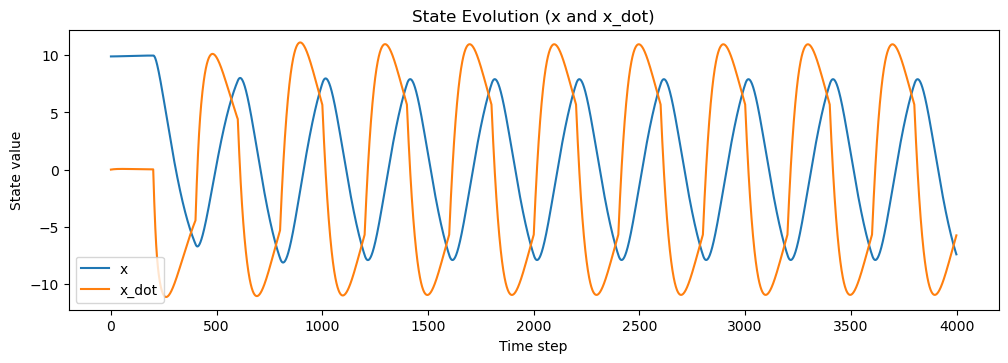

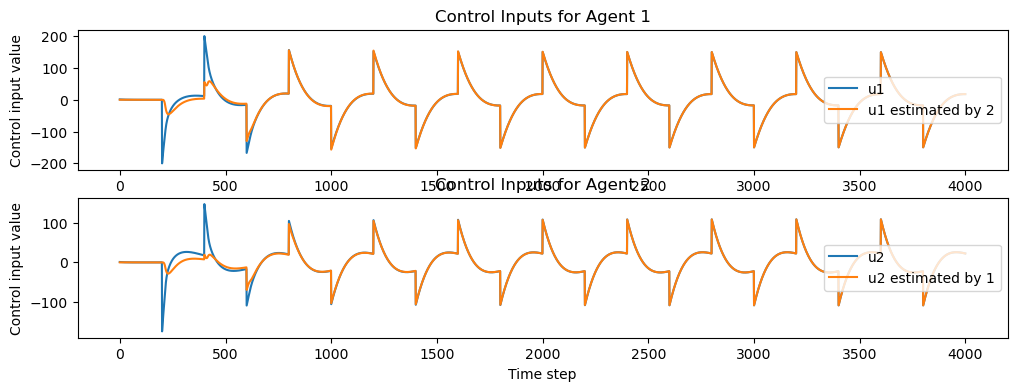

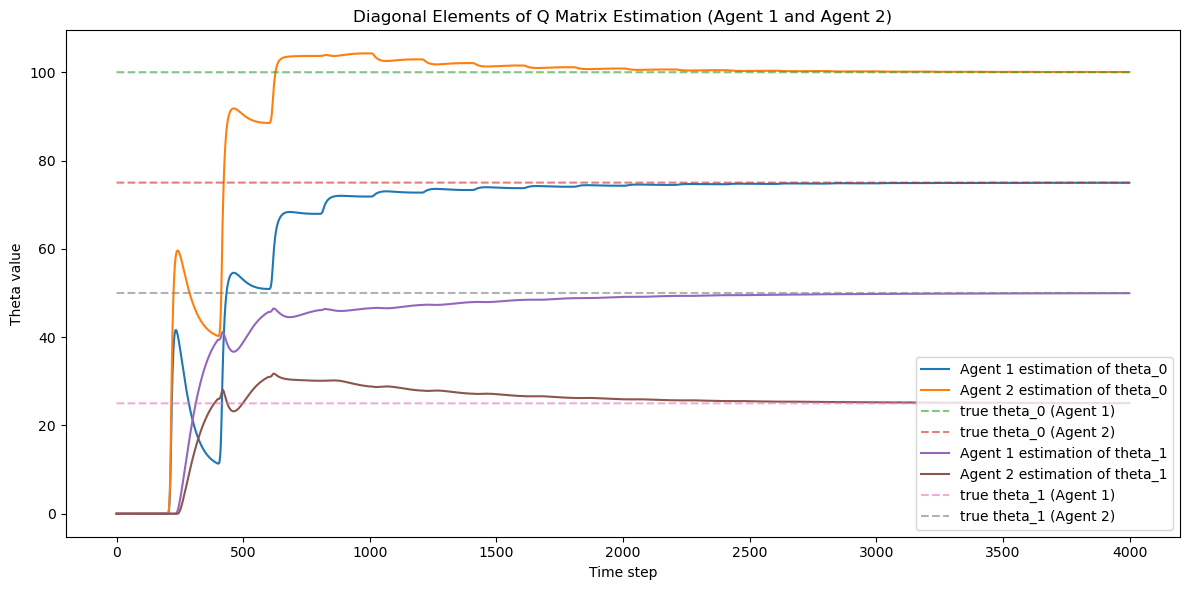

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Updated Example matrices based on the MATLAB-to-Python translation
M = 6  # Mass of the system
C = -0.2  # Damping coefficient

A = np.array([[0, 1],
              [0, -C / M]], dtype=np.float32)

B1 = np.array([[0],
               [1 / M]], dtype=np.float32)  # Updated B matrix for agent 1

B2 = B1.copy()  # Assuming both agents have the same dynamics

Q1 = np.diag([100, 25])  # 2x2 state cost matrix for Agent 1 (according to the MATLAB code)
Q2 = np.diag([75, 50])  # 2x2 state cost matrix for Agent 2 (as in MATLAB)

R = np.eye(1)  # 1x1 identity matrix for the control cost

# Initial guesses for the other agent's gain matrices (1x2)
K2_init = 0.0 * np.ones((1, 2))  # 1x2 gain matrix (one input, two states)
K1_init = 0.0 * np.ones((1, 2))  # 1x2 gain matrix (one input, two states)

# Initial xd and initial state in terms of error (e1, e2)
xd = 0.1
initial_state = np.array([-xd, 0.0])  # e1 = x - xd = -xd, e2 = x_dot = 0

# Initialize the environment
env = Environment(initial_state, dt=0.01)

# Initialize agents
agent1 = Agent(A, B1, Q1, B2, K2_init)  # B2 passed as other agent's input matrix
agent2 = Agent(A, B2, Q2, B1, K1_init)  # B1 passed as other agent's input matrix

# Simulation parameters
num_steps = 4000
flip_interval = 200  # Interval to flip xd

# Data storage for plotting
e1_history = []
e2_history = []
u1_history = []
u2_history = []
u1_other_history = []
u2_other_history = []
Q1_diag_history = [[] for _ in range(len(agent1.theta_other))]  # Store different theta estimates for Agent 1
Q2_diag_history = [[] for _ in range(len(agent2.theta_other))]  # Store different theta estimates for Agent 2
Q1_diag_true = [100, 25]  # True values of Q1's diagonal (same for all steps)
Q2_diag_true = [75,50]  # True values of Q2's diagonal (same for all steps)
blame_me_costs_agent1 = []
blame_me_costs_agent2 = []

# Reset the environment
state = env.reset()

# Run the simulation
agent1.solve_riccati()
agent2.solve_riccati()

for step in range(num_steps):
    # Flip xd every 200 steps
    if step % flip_interval == 0 and step != 0:
        env.flip_xd()
        state = env.current_state
        blame_me_costs_agent1.append(agent1.total_cost[0][0]/flip_interval)
        blame_me_costs_agent2.append(agent2.total_cost[0][0]/flip_interval)
        agent1.reset_history()
        agent2.reset_history()
        

    agent1.solve_riccati()
    agent2.solve_riccati()

    # Get control inputs
    u1 = agent1.get_control_input(state)
    u2 = agent2.get_control_input(state)

    # Append the error state (e1 and e2) as a row vector
    e1_history.append(state[0] + env.xd)  # Plotting x = e1 + xd
    e2_history.append(state[1])  # e2 is equivalent to x_dot
    u1_history.append(u1.flatten())  # Ensure control inputs are stored as 1D
    u2_history.append(u2.flatten())
    u1_other_history.append(agent1.u_other.flatten())
    u2_other_history.append(agent2.u_other.flatten())

    # Update the state using the error dynamics
    agent1.update_state_history(state,u2)
    agent2.update_state_history(state,u1)

    # Compute next state using error dynamics (e1, e2)
    state = env.next_state(u1, u2)

    # Store the estimations of thetas for Agent 1 and Agent 2
    for i in range(len(agent1.theta_other)):
        Q1_diag_history[i].append(agent1.theta_other[i])
        Q2_diag_history[i].append(agent2.theta_other[i])

    # Perform gradient descent updates on theta_other
    agent1.gradient_descent_update()
    agent2.gradient_descent_update()
    print(agent1.theta_other)

# Convert to numpy arrays for plotting
e1_history = np.array(e1_history)  # Use vstack to ensure correct 2D shape
e2_history = np.array(e2_history)  # Use vstack for consistent 2D shape
u1_history = np.array(u1_history)  # Use vstack for consistent 2D shape
u2_history = np.array(u2_history)
u1_other_history = np.array(u1_other_history)
u2_other_history = np.array(u2_other_history)

# Plot state evolution (x = e1 + xd)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(e1_history, label='x')  # x is e1 + xd
plt.plot(e2_history, label='x_dot')  # x_dot is e2
plt.legend()
plt.title('State Evolution (x and x_dot)')
plt.xlabel('Time step')
plt.ylabel('State value')

# Plot control inputs
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(u1_history[:, 0], label='u1')
plt.plot(u2_other_history[:, 0], label='u1 estimated by 2')
plt.legend(loc='center right')
plt.title('Control Inputs for Agent 1')
plt.xlabel('Time step')
plt.ylabel('Control input value')

plt.subplot(2, 1, 2)
plt.plot(u2_history[:, 0], label='u2')
plt.plot(u1_other_history[:, 0], label='u2 estimated by 1')
plt.legend(loc='center right')
plt.title('Control Inputs for Agent 2')
plt.xlabel('Time step')
plt.ylabel('Control input value')

# Plot diagonal elements of Q matrix of Agent 1 and Agent 2's estimation
plt.figure(figsize=(12, 6))
for i in range(len(agent1.theta_other)):
    plt.plot(Q1_diag_history[i], label=f'Agent 1 estimation of theta_{i}')
    plt.plot(Q2_diag_history[i], label=f'Agent 2 estimation of theta_{i}')
    plt.plot([Q1_diag_true[i]] * num_steps, '--', label=f'true theta_{i} (Agent 1)', alpha=0.6)
    plt.plot([Q2_diag_true[i]] * num_steps, '--', label=f'true theta_{i} (Agent 2)', alpha=0.6)

Q1_diag_0_history_me = Q1_diag_history[0]
Q1_diag_1_history_me = Q1_diag_history[1]
Q2_diag_0_history_me = Q2_diag_history[0]
Q2_diag_1_history_me = Q2_diag_history[1]
Q1_0_true = [Q1_diag_true[0]] * num_steps
Q1_1_true = [Q1_diag_true[1]] * num_steps
Q2_0_true = [Q2_diag_true[0]] * num_steps
Q2_1_true = [Q2_diag_true[1]] * num_steps


plt.legend()
plt.title('Diagonal Elements of Q Matrix Estimation (Agent 1 and Agent 2)')
plt.xlabel('Time step')
plt.ylabel('Theta value')
plt.tight_layout()
plt.show()


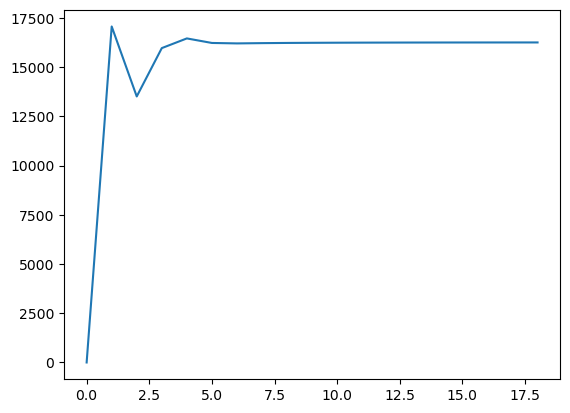

In [18]:
plt.plot(blame_me_costs_agent2)

In [4]:
import numpy as np
from scipy.linalg import solve_continuous_are, solve_continuous_lyapunov

class AgentBlameAll:
    def __init__(self, A, B, Q_actual, other_agent_B, other_agent_K_init, dt=0.01, learning_rate=0.1, history_size=15):
        """
        Initializes the agent with system matrices and cost matrices.
        """
        self.A = A
        self.B = B
        self.Q_actual = Q_actual  # This is the actual Q of the first agent (Agent 1's true objective)
        self.R = np.eye(B.shape[1])  # Custom R matrix for control
        self.other_agent_B = other_agent_B
        self.other_agent_K = other_agent_K_init
        self.K_self_for_other = other_agent_K_init
        self.u_other = 0

        self.dt = dt
        self.P = np.eye(A.shape[0])  # Initialize the Riccati matrix P
        self.K = None
        self.history_size = history_size
        self.state_history = []
        self.u_self_history = []  # History for Agent 1's inputs
        self.K_history = []
        self.u_other_history = []  # History for Agent 2's inputs
        self.other_agent_K_history = []
        self.K_self_for_other_history = []

        # Initialize theta for both agents as vectors (one theta per diagonal element of Q)
        self.theta_self = np.random.uniform(0.0001, 0.0001001, A.shape[0])  # Vector of thetas for self
        self.theta_other = np.random.uniform(0.0001, 0.0001001, A.shape[0])  # Vector of thetas for the other agent

        # Initial Riccati matrices for both agents
        self.P_other = np.eye(A.shape[0])  # Initial Riccati matrix for the other agent
        self.P_self_for_other = np.eye(A.shape[0])  # Agent's guess of the Riccati matrix the other agent is using to estimate their gain
        self.learning_rate = learning_rate
        self.total_cost = 0

    def solve_riccati(self):
        """
        Solves the Riccati equation for control based on the actual Q of the first agent and
        the current estimate of the other agent's gain.
        """
        A_eff_self = self.A - self.other_agent_B @ self.other_agent_K  # Effective dynamics for self
        try:
            P_self = solve_continuous_are(A_eff_self, self.B, self.Q_actual, self.R)  # Solve ARE using the actual Q of the first agent
            self.P = P_self
            self.K = self.B.T @ P_self  # Control gain for self
        except np.linalg.LinAlgError:
            print("Error in solving Riccati equation for control")
            self.P = np.eye(self.A.shape[0]) * 0.01
            self.K = np.zeros((self.B.shape[1], self.A.shape[0]))

    def estimate_P_other(self, K_self_est):
        """
        Solves the Riccati equation for the other agent to estimate P_other based on theta_other (vector).
        The Riccati equation for the other agent uses the current K_self of this agent.
        """
        Q_other = np.diag(self.theta_other)  # Diagonal matrix for the other agent's Q
        A_eff_other = self.A - self.B @ K_self_est  # The other agent assumes they know our current K_self
        try:
            P_other = solve_continuous_are(A_eff_other, self.other_agent_B, Q_other, self.R)  # Solving ARE for the other agent
            self.P_other = P_other
            self.other_agent_K = self.other_agent_B.T @ P_other  # Gain for the other agent
        except np.linalg.LinAlgError:
            print("Error in solving Riccati equation for other agent")
            self.P_other = np.eye(self.A.shape[0]) * 0.01
            self.other_agent_K = np.zeros((self.other_agent_B.shape[1], self.A.shape[0]))

    def estimate_P_self_for_other(self, other_K_est):
        """
        Solves the Riccati equation for how the other agent is estimating the self agent.
        The Riccati equation models how the other agent is solving for this agent's gain K_self using its own theta_self estimate.
        """
        Q_self_for_other = np.diag(self.theta_self)  # Estimate of self's Q from other agent's perspective
        A_eff_self_for_other = self.A - self.other_agent_B @ other_K_est  # Use the other agent's current gain estimation of self
        try:
            P_self_for_other = solve_continuous_are(A_eff_self_for_other, self.B, Q_self_for_other, self.R)  # Solve ARE for how the other agent sees self
            self.P_self_for_other = P_self_for_other
            self.K_self_for_other = self.B.T @ P_self_for_other  # Estimate of self's gain from other agent's perspective
        except np.linalg.LinAlgError:
            print("Error in solving Riccati equation for self as seen by other agent")
            self.P_self_for_other = np.eye(self.A.shape[0]) * 0.01
            self.K_self_for_other = np.zeros((self.B.shape[1], self.A.shape[0]))

    def compute_dP_self_dtheta(self, theta_index, other_K_est):
        """
        Computes dP_self/dtheta for the given theta index by solving the Lyapunov equation.
        """
        A_eff_self = self.A - self.other_agent_B @ other_K_est
        A_lya_self = A_eff_self - self.B @ self.B.T @ self.P_self_for_other
        I_theta_self = np.zeros_like(self.A)
        I_theta_self[theta_index, theta_index] = 1.0
        dP_self_dtheta = solve_continuous_lyapunov(A_lya_self.T, I_theta_self)
        return dP_self_dtheta

    def compute_dP_other_dtheta(self, theta_index, K_self_est):
        """
        Computes dP_other/dtheta_other for the given theta index by solving the Lyapunov equation for the other agent.
        """
        A_eff_other = self.A - self.B @ K_self_est  # Using the other agent's estimation of our gain
        A_lya_other = A_eff_other - self.other_agent_B @ self.other_agent_B.T @ self.P_other
        I_theta_other = np.zeros_like(self.A)
        I_theta_other[theta_index, theta_index] = 1.0
        dP_other_dtheta = solve_continuous_lyapunov(A_lya_other.T, I_theta_other)
        return dP_other_dtheta

    def get_control_input(self, state):
        """
        Computes the control input given the current state.
        Uses the gain matrix K derived from the Riccati equation solution.
        """
        if self.K is None:
            raise ValueError("K matrix has not been computed. Call solve_riccati() first.")
        self.u_other = -self.other_agent_K @ state
        control_signal = -self.K @ state
        self.total_cost = self.total_cost + control_signal.T@control_signal + state.T@self.Q_actual@state
        return control_signal

    def update_state_history(self, state, u_self, u_other):
        """
        Updates the state history with the latest state and the control inputs (both self and other agent).
        """
        if len(self.state_history) > self.history_size:
            self.state_history.pop(0)
            self.u_self_history.pop(0)
            self.u_other_history.pop(0)
            self.K_history.pop(0)
            self.other_agent_K_history.pop(0)
            self.K_self_for_other_history.pop(0)

        self.state_history.append(state)
        self.u_self_history.append(u_self)
        self.u_other_history.append(u_other)
        self.K_history.append(self.K)
        self.other_agent_K_history.append(self.other_agent_K)
        self.K_self_for_other_history.append(self.K_self_for_other)
    
    def reset_history(self):
        self.state_history = []
        self.K_history = []
        self.u_other_history = []
        self.K_self_for_other_history = []
        self.other_agent_K_history = []
        self.total_cost = 0
        
    def simulate_trajectory_and_compute_error(self):
        """
        Simulates the trajectory with the estimated parameters for both agents, computing the error 
        between the estimated and actual trajectories based on stored states.
        """
        error_sum_self = np.zeros(len(self.theta_self))
        error_sum_other = np.zeros(len(self.theta_other))

        estimated_state_self = self.state_history[0]
        estimated_state_other = self.state_history[0]

        d_error_dtheta_self = [np.zeros_like(estimated_state_self) for _ in range(len(self.theta_other))]
        d_error_dtheta_other = [np.zeros_like(estimated_state_self) for _ in range(len(self.theta_other))]
        
        error_self = self.state_history[0] - self.state_history[0]
        error_other = self.state_history[0] - self.state_history[0]

        for i in range(1,len(self.state_history)):
            # Update K_self and P_other based on history
            self.estimate_P_self_for_other(self.other_agent_K_history[i-1])
            self.estimate_P_other(self.K_self_for_other_history[i-1])

            # Compute controls
            u_self = -self.K_history[i-1] @ self.state_history[i-1]
            #u_self = self.u_self_history[i-1]
            u_other_predicted_self = -self.other_agent_K @ self.state_history[i-1]
            u_self_other = -self.K_self_for_other@self.state_history[i-1]
            

            estimated_state_self = estimated_state_self + self.dt * (self.A @ estimated_state_self + self.B @ u_self + self.other_agent_B @ u_other_predicted_self)
            

            error_other = self.state_history[i] - estimated_state_self
            d_error_self = self.A@error_self + self.B@(-u_self_other+u_self)
            error_self = error_self + self.dt*d_error_self

            for j in range(len(self.theta_self)):
                dP_self_dtheta_j = self.compute_dP_self_dtheta(j, self.other_agent_K_history[i-1])
                du_self_dtheta_j = -self.B.T @ dP_self_dtheta_j @ self.state_history[i-1] #-self.B.T @ self.P_self_for_other @ d_error_dtheta_self[j] 
                d_error_dot_dtheta_self = self.A @ d_error_dtheta_self[j] + self.B @ du_self_dtheta_j
                d_error_dtheta_self[j] = d_error_dtheta_self[j] + self.dt * d_error_dot_dtheta_self
                error_sum_self[j] += 100*error_self.T @ d_error_dtheta_self[j]

                dP_other_dtheta_j = self.compute_dP_other_dtheta(j, self.K_self_for_other_history[i-1])
                du_other_dtheta_j = -self.other_agent_B.T @ dP_other_dtheta_j @ self.state_history[i-1] #- self.other_agent_B.T @ self.P_other @ d_error_dtheta_other[j]
                d_error_dot_dtheta_other = self.A @ d_error_dtheta_other[j] + self.other_agent_B @ du_other_dtheta_j
                d_error_dtheta_other[j] = d_error_dtheta_other[j] + self.dt * d_error_dot_dtheta_other
                error_sum_other[j] += 100*error_other.T @ d_error_dtheta_other[j]

            #estimated_state_self = next_estimated_state_self
            #estimated_state_other = next_estimated_state_other

        return error_sum_self, error_sum_other

    def gradient_descent_update(self):
        """
        Updates theta_self and theta_other using gradient descent based on the recomputed errors.
        """
        error_sum_self, error_sum_other = self.simulate_trajectory_and_compute_error()
        self.theta_self -= self.learning_rate * error_sum_self
        self.theta_other -= self.learning_rate * error_sum_other
        self.theta_self = np.maximum(self.theta_self, 1e-6)
        self.theta_other = np.maximum(self.theta_other, 1e-6)
        for i in range(10):
            self.estimate_P_self_for_other(self.other_agent_K)
            self.estimate_P_other(self.K_self_for_other)


[0.00010009 0.00010004]
[0.00020407 0.00010004]
[5.03807273e-04 9.98240017e-05]
[9.78661438e-04 9.89555698e-05]
[1.63079221e-03 9.67180778e-05]
[2.46352415e-03 9.21037451e-05]
[3.47759375e-03 8.38085860e-05]
[4.67113963e-03 7.02319247e-05]
[6.04003024e-03 4.94783962e-05]
[7.57816801e-03 1.93617501e-05]
[9.27772676e-03 1.00000000e-06]
[1.11293675e-02 1.00000000e-06]
[1.31223461e-02 1.00000000e-06]
[1.52445385e-02 1.00000000e-06]
[1.74825015e-02 1.00000000e-06]
[1.98214614e-02 1.00000000e-06]
[2.10741832e-02 1.00000000e-06]
[2.14153378e-02 1.00000000e-06]
[2.09290836e-02 1.00000000e-06]
[1.96388562e-02 1.00000000e-06]
[1.75047084e-02 1.00000000e-06]
[1.43903174e-02 1.00000000e-06]
[9.95291748e-03 1.00000000e-06]
[3.19818543e-03 1.00000000e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 1.e-06]
[1.e-06 

[35.12323504 18.08848777]
[35.08332144 18.27271495]
[35.04474256 18.45468815]
[35.0074699  18.63441524]
[34.97147534 18.81190492]
[34.93673116 18.98716662]
[34.90321    19.16021052]
[34.8708849  19.33104743]
[34.83972929 19.49968876]
[34.80971699 19.66614652]
[34.78082222 19.83043321]
[34.75301959 19.99256185]
[34.72628413 20.15254589]
[34.70059123 20.31039919]
[34.67591669 20.46613601]
[34.65223673 20.61977095]
[34.62952793 20.77131893]
[34.60776726 20.92079518]
[34.58693209 21.06821519]
[34.56700018 21.2135947 ]
[34.54794966 21.35694967]
[34.52975902 21.49829626]
[34.51240716 21.63765084]
[34.49587334 21.77502991]
[34.48013715 21.91045015]
[34.46517859 22.04392833]
[34.450978   22.17548139]
[34.43751606 22.30512632]
[34.4247738  22.43288024]
[34.41273262 22.55876033]
[34.40137423 22.68278383]
[34.39068069 22.80496803]
[34.38063439 22.92533029]
[34.37121803 23.04388799]
[34.36241465 23.16065852]
[34.3542076 23.2756593]
[34.34658054 23.38890777]
[34.33951743 23.50042136]
[34.33300255 2

[64.51794402 35.92303678]
[64.61633705 35.88998146]
[64.70626018 35.85806616]
[64.78817419 35.82743579]
[64.86251475 35.7982201 ]
[64.92969425 35.77053476]
[64.99010346 35.74448234]
[65.04411293 35.72015319]
[65.09207439 35.6976263 ]
[65.13432192 35.6769701 ]
[65.17117305 35.6582431 ]
[65.20292981 35.64149463]
[65.22987959 35.62676541]
[65.25229601 35.61408818]
[65.27043968 35.60348819]
[65.28455891 35.59498374]
[65.29489037 35.58858669]
[65.30165967 35.58430283]
[65.30508194 35.5821324 ]
[65.30536235 35.58207043]
[65.30269655 35.58410716]
[65.29727118 35.58822837]
[65.28926422 35.59441574]
[65.27884545 35.60264721]
[65.26617677 35.61289721]
[65.25141254 35.62513702]
[65.23469995 35.63933503]
[65.21617929 35.655457  ]
[65.19598426 35.67346629]
[65.17424223 35.69332414]
[65.15107449 35.71498988]
[65.12659657 35.73842112]
[65.10091836 35.76357399]
[65.07414445 35.7904033 ]
[65.04637428 35.81886273]
[65.01770236 35.84890501]
[64.98821848 35.88048208]
[64.95800789 35.91354524]
[64.92715147

[68.06668069 43.84363721]
[68.06181568 43.86911126]
[68.05714248 43.8942995 ]
[68.05265738 43.91920103]
[68.04835663 43.94381514]
[68.04423654 43.96814125]
[68.04029342 43.99217893]
[68.03652362 44.01592787]
[68.03292348 44.03938791]
[68.0294894  44.06255902]
[68.02621779 44.08544127]
[68.02310509 44.10803488]
[68.02014779 44.13034014]
[68.01734239 44.1523575 ]
[68.01468542 44.17408747]
[68.01217346 44.19553069]
[68.00980313 44.21668789]
[68.00757105 44.23755988]
[68.00547392 44.25814757]
[68.00350846 44.27845196]
[68.00167142 44.29847413]
[67.9999596  44.31821524]
[67.99836983 44.33767651]
[67.996899   44.35685925]
[67.99554401 44.37576483]
[67.99430184 44.3943947 ]
[67.99316947 44.41275035]
[67.99214394 44.43083336]
[67.99122235 44.44864534]
[67.9904018  44.46618798]
[67.98967948 44.483463  ]
[67.98905259 44.50047219]
[67.98851837 44.51721737]
[67.98807413 44.53370043]
[67.9877172  44.54992327]
[67.98744495 44.56588785]
[67.9872548  44.58159619]
[67.98714422 44.5970503 ]
[67.98711072

[72.99982134 46.85053872]
[72.99381343 46.85592612]
[72.98757028 46.86165417]
[72.98111254 46.86771462]
[72.97445988 46.87409897]
[72.96763105 46.88079851]
[72.96064392 46.88780434]
[72.95351552 46.89510745]
[72.94626202 46.90269865]
[72.93889884 46.91056871]
[72.9314406  46.91870827]
[72.92390122 46.92710796]
[72.91629389 46.93575835]
[72.90863111 46.94465001]
[72.90092477 46.9537735 ]
[72.89318608 46.96311942]
[72.88542566 46.97267838]
[72.87765357 46.98244108]
[72.86987929 46.99239824]
[72.86211176 47.00254068]
[72.85435941 47.01285932]
[72.84663017 47.02334515]
[72.8389315  47.03398931]
[72.83127041 47.044783  ]
[72.82365346 47.05571761]
[72.81608678 47.06678461]
[72.80857613 47.07797565]
[72.80112685 47.08928249]
[72.79374395 47.10069707]
[72.78643204 47.11221146]
[72.77919544 47.12381793]
[72.77203812 47.13550886]
[72.76496374 47.14727683]
[72.75797568 47.15911459]
[72.75107703 47.17101503]
[72.74427062 47.18297126]
[72.73755902 47.19497652]
[72.73094455 47.20702423]
[72.72442931

[73.50062642 48.78454695]
[73.50052756 48.78820529]
[73.50044877 48.79180606]
[73.50038945 48.79534969]
[73.50034901 48.79883659]
[73.50032687 48.80226719]
[73.50032246 48.80564194]
[73.50033522 48.80896129]
[73.50036459 48.81222568]
[73.50041004 48.81543559]
[73.50047102 48.81859148]
[73.50047102 48.81859148]
[73.50051554 48.81860301]
[73.50073574 48.81865848]
[73.50134584 48.81880809]
[73.50263932 48.81911671]
[73.50498475 48.819661  ]
[73.50882059 48.8205263 ]
[73.5146486  48.82180352]
[73.52302528 48.82358576]
[73.53455057 48.82596476]
[73.54985339 48.82902698]
[73.56957345 48.83284954]
[73.59433892 48.83749589]
[73.62473996 48.84301141]
[73.66129821 48.84941924]
[73.70443313 48.85671636]
[73.74504181 48.86287967]
[73.78327366 48.8680185 ]
[73.81926707 48.87223278]
[73.85315041 48.87561392]
[73.88504294 48.87824563]
[73.91505562 48.88020465]
[73.94329185 48.88156142]
[73.96984814 48.8823806 ]
[73.99481466 48.88272163]
[74.01827581 48.88263919]
[74.04031066 48.88218358]
[74.06099343

[74.50941802 49.37265062]
[74.50789206 49.3752795 ]
[74.50638698 49.37791991]
[74.50490331 49.38057041]
[74.50344153 49.38322959]
[74.50200209 49.38589607]
[74.50058536 49.38856853]
[74.49919169 49.39124565]
[74.49782138 49.39392617]
[74.49647469 49.39660887]
[74.49515185 49.39929256]
[74.49385303 49.40197609]
[74.4925784  49.40465832]
[74.49132806 49.4073382 ]
[74.4901021  49.41001466]
[74.48890059 49.41268669]
[74.48772355 49.41535332]
[74.486571  49.4180136]
[74.4854429  49.42066663]
[74.48433922 49.42331152]
[74.48325988 49.42594743]
[74.48220482 49.42857354]
[74.48117391 49.43118908]
[74.48016705 49.43379329]
[74.47918408 49.43638545]
[74.47822486 49.43896487]
[74.47728921 49.44153089]
[74.47637695 49.44408286]
[74.47548789 49.44662019]
[74.47462181 49.44914229]
[74.47377849 49.45164861]
[74.47295771 49.45413861]
[74.47215923 49.4566118 ]
[74.4713828 49.4590677]
[74.47062816 49.46150585]
[74.46989505 49.46392582]
[74.4691832 49.4663272]
[74.46849233 49.4687096 ]
[74.46782217 49.47

[74.7731042  49.75218253]
[74.77859785 49.75226805]
[74.78376197 49.75226008]
[74.78861367 49.75216964]
[74.79316905 49.75200689]
[74.79744323 49.75178118]
[74.80145045 49.75150115]
[74.80520415 49.75117476]
[74.80871699 49.75080933]
[74.81200094 49.75041163]
[74.81506731 49.7499879 ]
[74.81792684 49.74954388]
[74.82058966 49.74908487]
[74.82306541 49.74861573]
[74.82536323 49.74814095]
[74.82749181 49.74766463]
[74.8294594  49.74719055]
[74.83127387 49.74672218]
[74.83294271 49.74626267]
[74.83447305 49.74581491]
[74.83587169 49.74538154]
[74.83714513 49.74496495]
[74.83829958 49.7445673 ]
[74.83934094 49.74419055]
[74.84027489 49.74383644]
[74.84110684 49.74350656]
[74.84184196 49.74320231]
[74.84248521 49.74292491]
[74.84304133 49.74267545]
[74.84351486 49.74245487]
[74.84391016 49.74226397]
[74.84423138 49.74210344]
[74.84448253 49.74197384]
[74.84466741 49.74187561]
[74.84478971 49.74180912]
[74.84485292 49.7417746 ]
[74.84486042 49.74177224]
[74.84481543 49.74180209]
[74.84472104

[74.88302143 49.88062168]
[74.88285828 49.88115799]
[74.88269986 49.8816902 ]
[74.8825461  49.88221823]
[74.88239693 49.88274199]
[74.88225231 49.88326141]
[74.88211216 49.8837764 ]
[74.88197642 49.88428692]
[74.88184502 49.88479288]
[74.8817179  49.88529424]
[74.88159498 49.88579093]
[74.88147621 49.8862829 ]
[74.88136151 49.88677011]
[74.88125082 49.88725251]
[74.88114406 49.88773007]
[74.88104117 49.88820273]
[74.88094209 49.88867048]
[74.88084673 49.88913327]
[74.88075504 49.88959109]
[74.88066694 49.8900439 ]
[74.88058236 49.89049168]
[74.88050125 49.89093442]
[74.88042352 49.8913721 ]
[74.88034912 49.89180471]
[74.88027797 49.89223223]
[74.88021001 49.89265466]
[74.88014517 49.89307199]
[74.88008338 49.89348422]
[74.88002459 49.89389135]
[74.87996872 49.89429337]
[74.8799157  49.89469029]
[74.87986549 49.89508211]
[74.879818   49.89546885]
[74.87977319 49.89585051]
[74.87973098 49.89622709]
[74.87969132 49.89659862]
[74.87965414 49.89696511]
[74.87961939 49.89732656]
[74.879587  

[74.96562584 49.94279802]
[74.96565295 49.9427833 ]
[74.96566697 49.94277566]
[74.96566865 49.94277513]
[74.96565869 49.94278173]
[74.96563779 49.94279545]
[74.96560659 49.94281629]
[74.96556573 49.94284421]
[74.96551581 49.94287917]
[74.9654574  49.94292111]
[74.96539106 49.94296997]
[74.96531732 49.94302565]
[74.96523668 49.94308808]
[74.96514963 49.94315716]
[74.96505662 49.94323276]
[74.96495811 49.94331479]
[74.96485452 49.94340311]
[74.96474626 49.9434976 ]
[74.9646337  49.94359812]
[74.96451722 49.94370454]
[74.96439717 49.94381671]
[74.96427389 49.94393447]
[74.9641477  49.94405769]
[74.96401891 49.9441862 ]
[74.9638878  49.94431985]
[74.96375466 49.94445848]
[74.96361974 49.94460192]
[74.9634833  49.94475002]
[74.96334558 49.94490262]
[74.96320681 49.94505954]
[74.96306719 49.94522063]
[74.96292693 49.94538573]
[74.96278622 49.94555466]
[74.96264526 49.94572728]
[74.9625042  49.94590341]
[74.96236321 49.94608289]
[74.96222244 49.94626558]
[74.96208205 49.9464513 ]
[74.96194216

[74.97337063 49.97691733]
[74.97336127 49.97700081]
[74.97335246 49.97708317]
[74.97334421 49.97716441]
[74.9733365  49.97724454]
[74.97332931 49.97732356]
[74.97332263 49.97740147]
[74.97331645 49.97747827]
[74.97331076 49.97755398]
[74.97330553 49.9776286 ]
[74.97330077 49.97770213]
[74.97329646 49.97777458]
[74.97329259 49.97784595]
[74.97328914 49.97791625]
[74.9732861  49.97798549]
[74.97328346 49.97805367]
[74.97328121 49.97812081]
[74.97327934 49.97818689]
[74.97327784 49.97825194]
[74.9732767  49.97831597]
[74.9732759  49.97837897]
[74.97327543 49.97844095]
[74.97327529 49.97850193]
[74.97327547 49.97856191]
[74.97327594 49.9786209 ]
[74.97327672 49.97867891]
[74.97327777 49.97873595]
[74.97327777 49.97873595]
[74.97327856 49.97873615]
[74.97328246 49.97873714]
[74.97329325 49.97873981]
[74.97331615 49.97874531]
[74.97335766 49.97875502]
[74.97342556 49.97877045]
[74.97352873 49.97879325]
[74.97367705 49.97882507]
[74.97388114 49.97886756]
[74.97415217 49.97892229]
[74.97450153

[74.99172407 49.9879727 ]
[74.9916928  49.98801172]
[74.99166155 49.98805149]
[74.99163035 49.98809197]
[74.99159923 49.98813312]
[74.99156822 49.98817491]
[74.99153736 49.98821731]
[74.99150666 49.98826028]
[74.99147615 49.98830378]
[74.99144586 49.98834779]
[74.9914158  49.98839228]
[74.991386   49.98843721]
[74.99135648 49.98848254]
[74.99132726 49.98852826]
[74.99129834 49.98857433]
[74.99126975 49.98862072]
[74.9912415 49.9886674]
[74.9912136  49.98871435]
[74.99118607 49.98876154]
[74.99115891 49.98880893]
[74.99113213 49.98885651]
[74.99110575 49.98890426]
[74.99107977 49.98895213]
[74.9910542  49.98900012]
[74.99102904 49.98904819]
[74.9910043  49.98909633]
[74.99097999 49.98914451]
[74.9909561  49.98919271]
[74.99093265 49.98924091]
[74.99090964 49.98928909]
[74.99088706 49.98933724]
[74.99086492 49.98938532]
[74.99084322 49.98943333]
[74.99082196 49.98948124]
[74.99080114 49.98952905]
[74.99078076 49.98957672]
[74.99076083 49.98962426]
[74.99074133 49.98967163]
[74.99072226 4

[74.99409653 49.99529226]
[74.99411157 49.99529568]
[74.99413443 49.99530073]
[74.99416729 49.99530778]
[74.99421251 49.9953172 ]
[74.99427257 49.99532932]
[74.99434997 49.99534447]
[74.99444722 49.9953629 ]
[74.99456662 49.99538478]
[74.99471028 49.99541023]
[74.99487986 49.99543924]
[74.99503961 49.99546379]
[74.9951901  49.99548432]
[74.99533187 49.9955012 ]
[74.9954654 49.9955148]
[74.99559115 49.99552545]
[74.99570955 49.99553344]
[74.995821   49.99553905]
[74.99592586 49.99554253]
[74.99602449 49.99554412]
[74.99611721 49.99554403]
[74.99620433 49.99554245]
[74.99628614 49.99553958]
[74.9963629  49.99553557]
[74.99643487 49.99553058]
[74.99650229 49.99552476]
[74.9965654  49.99551824]
[74.99662439 49.99551114]
[74.99667948 49.99550356]
[74.99673086 49.99549562]
[74.9967787  49.99548741]
[74.99682319 49.99547902]
[74.99686448 49.99547052]
[74.99690273 49.99546199]
[74.99693809 49.9954535 ]
[74.9969707  49.99544511]
[74.9970007  49.99543688]
[74.9970282  49.99542885]
[74.99705335 4

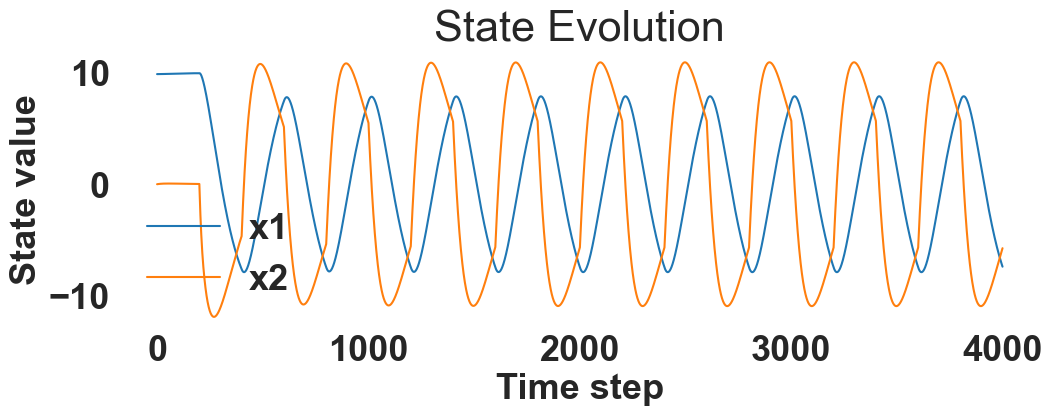

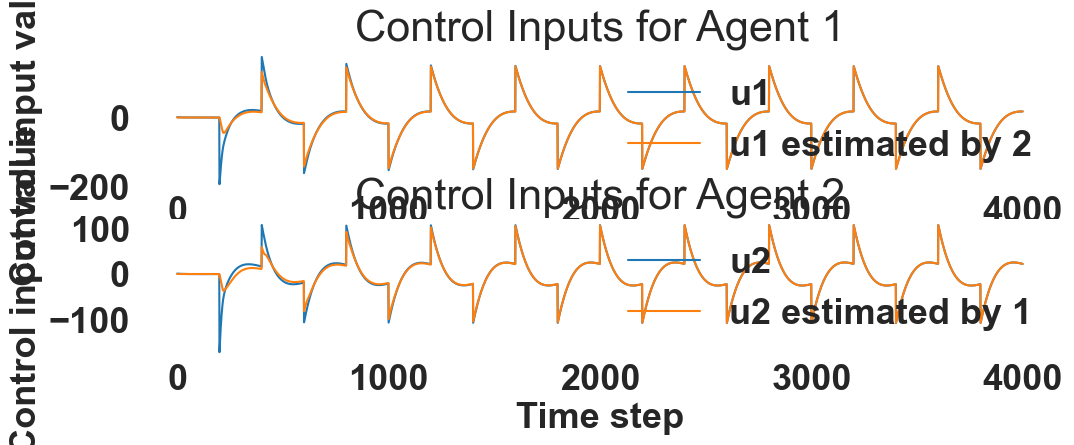

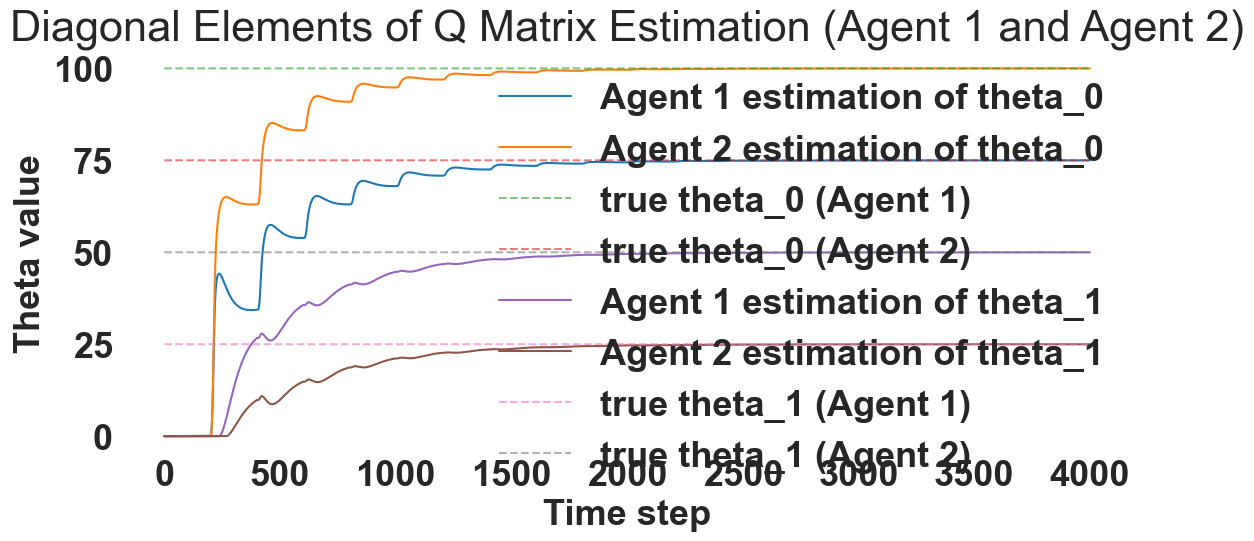

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Updated Example matrices for 2D system
M = 6  # Mass of the system
C = -0.2  # Damping coefficient

A = np.array([[0, 1],
              [0, -C / M]], dtype=np.float32)

B1 = np.array([[0],
               [1 / M]], dtype=np.float32)  # Updated B matrix for agent 1

B2 = B1.copy()  # Assuming both agents have the same dynamics

# True cost matrices for Agent 1 and Agent 2
Q1_true = np.diag([100, 25])  # True cost matrix for agent 1
Q2_true = np.diag([75, 50])  # True cost matrix for agent 2
R = np.eye(1)  # 1x1 identity matrix for the control cost

# Initial guesses for the other agent's gain matrices (1x2)
K2_init = 0 * np.ones((1, 2))  # 1x2 gain matrix (one input, two states)
K1_init = 0 * np.ones((1, 2))  # 1x2 gain matrix (one input, two states)

# Initial xd and initial state in terms of error (e1, e2)
xd = 0.1
initial_state = np.array([-xd, 0.0])  # e1 = x - xd = -xd, e2 = x_dot = 0

# Initialize the environment
env = Environment(initial_state, dt=0.01)

# Initialize agents
agent1 = AgentBlameAll(A, B1, Q1_true, B2, K2_init)  # B2 passed as other agent's input matrix
agent2 = AgentBlameAll(A, B2, Q2_true, B1, K1_init)  # B1 passed as other agent's input matrix

# Simulation parameters
num_steps = 4000  # Consistent with previous MATLAB-to-Python code
flip_interval = 200  # Interval to flip xd

# Data storage for plotting
state_history = []
u1_history = []
u2_history = []
u1_other_history = []
u2_other_history = []
Q1_diag_history = [[] for _ in range(len(agent1.theta_other))]  # Store different theta estimates for Agent 1
Q2_diag_history = [[] for _ in range(len(agent2.theta_other))]  # Store different theta estimates for Agent 2
Q1_diag_true = [100, 25]  # True values of Q1's diagonal (same for all steps)
Q2_diag_true = [75, 50]  # True values of Q2's diagonal (same for all steps)
blame_all_costs_agent1 = []
blame_all_costs_agent2 = []

# Reset the environment
state = env.reset()

# Run the simulation
for i in range(50):
    agent1.estimate_P_self_for_other(agent1.other_agent_K)
    agent2.estimate_P_self_for_other(agent2.other_agent_K)
    agent1.estimate_P_other(agent1.K_self_for_other)
    agent2.estimate_P_other(agent2.K_self_for_other)
    
agent1.solve_riccati()
agent2.solve_riccati()

for step in range(num_steps):
    # Flip xd every 'flip_interval' steps
    # Flip xd every 200 steps
    if step % flip_interval == 0 and step != 0:
        env.flip_xd()
        state = env.current_state
        blame_all_costs_agent1.append(agent1.total_cost[0][0]/flip_interval)
        blame_all_costs_agent2.append(agent2.total_cost[0][0]/flip_interval)
        agent1.reset_history()
        agent2.reset_history()
    
    agent1.solve_riccati()
    agent2.solve_riccati()
    
    # Get control inputs
    u1 = agent1.get_control_input(state)
    u2 = agent2.get_control_input(state)
    
    # Append the state as a row vector
    state_history.append((state[0, 0] + env.xd, state[1, 0]))  # Correct the plotting to show x, not e1
    u1_history.append(u1.flatten())  # Ensure control inputs are stored as 1D
    u2_history.append(u2.flatten())
    u1_other_history.append(agent1.u_other.flatten())
    u2_other_history.append(agent2.u_other.flatten())

    # Update the state
    agent1.update_state_history(state, u1, u2)
    agent2.update_state_history(state, u2, u1)

    # Compute next state
    state = env.next_state(u1, u2)

    # Store the estimations of thetas for Agent 1 and Agent 2
    for i in range(len(agent1.theta_other)):
        Q1_diag_history[i].append(agent1.theta_other[i])
        Q2_diag_history[i].append(agent2.theta_other[i])

    # Perform gradient descent updates on theta_other
    agent1.gradient_descent_update()
    agent2.gradient_descent_update()
    print(agent1.theta_other)


# Convert to numpy arrays for plotting
state_history = np.array(state_history)  # Use vstack to ensure correct 2D shape
u1_history = np.array(u1_history)  # Use vstack for consistent 2D shape
u2_history = np.array(u2_history)
u1_other_history = np.array(u1_other_history)
u2_other_history = np.array(u2_other_history)

# Plot state evolution
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(state_history[:, 0], label='x1')  # Now state_history is (num_steps, 2)
plt.plot(state_history[:, 1], label='x2')
plt.legend()
plt.title('State Evolution')
plt.xlabel('Time step')
plt.ylabel('State value')

# Plot control inputs
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(u1_history[:, 0], label='u1')
plt.plot(u2_other_history[:, 0], label='u1 estimated by 2')
plt.legend(loc='center right')
plt.title('Control Inputs for Agent 1')
plt.xlabel('Time step')
plt.ylabel('Control input value')

plt.subplot(2, 1, 2)
plt.plot(u2_history[:, 0], label='u2')
plt.plot(u1_other_history[:, 0], label='u2 estimated by 1')
plt.legend(loc='center right')
plt.title('Control Inputs for Agent 2')
plt.xlabel('Time step')
plt.ylabel('Control input value')

# Plot diagonal elements of Q matrix of Agent 1 and Agent 2's estimation
plt.figure(figsize=(12, 6))
for i in range(len(agent1.theta_other)):
    plt.plot(Q1_diag_history[i], label=f'Agent 1 estimation of theta_{i}')
    plt.plot(Q2_diag_history[i], label=f'Agent 2 estimation of theta_{i}')
    plt.plot([Q1_diag_true[i]] * num_steps, '--', label=f'true theta_{i} (Agent 1)', alpha=0.6)
    plt.plot([Q2_diag_true[i]] * num_steps, '--', label=f'true theta_{i} (Agent 2)', alpha=0.6)
    
Q1_diag_0_history_all = Q1_diag_history[0]
Q1_diag_1_history_all = Q1_diag_history[1]
Q2_diag_0_history_all = Q2_diag_history[0]
Q2_diag_1_history_all = Q2_diag_history[1]
Q1_0_true = [Q1_diag_true[0]] * num_steps
Q1_1_true = [Q1_diag_true[1]] * num_steps
Q2_0_true = [Q2_diag_true[0]] * num_steps
Q2_1_true = [Q2_diag_true[1]] * num_steps

plt.legend()
plt.title('Diagonal Elements of Q Matrix Estimation (Agent 1 and Agent 2)')
plt.xlabel('Time step')
plt.ylabel('Theta value')

plt.tight_layout()
plt.show()


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Ensure proper backend and reset settings
matplotlib.use('Agg')  # Non-interactive backend for saving plots
plt.rcdefaults()  # Reset to default settings

def save_plots_png(state_history, u1_history, u2_history, u1_other_history, u2_other_history):
    font_size = 16
    line_width = 2.5

    # Plot state evolution
    plt.figure(figsize=(12, 8))
    plt.plot(state_history[:, 0], label='x1 (Position)', linewidth=line_width)
    plt.plot(state_history[:, 1], label='x2 (Velocity)', linewidth=line_width)
    plt.title('State Evolution', fontsize=font_size)
    plt.xlabel('Time step', fontsize=font_size)
    plt.ylabel('State value', fontsize=font_size)
    plt.legend(fontsize=font_size)
    plt.grid(True)  # Enable grid
    plt.axis('on')  # Ensure axes are visible
    plt.tight_layout(pad=2.0)
    plt.savefig("AppendixB_2D_states.png", format="png", dpi=300)
    plt.close()

    # Plot control inputs
    plt.figure(figsize=(12, 8))
    
    # Control inputs for Agent 1
    plt.subplot(2, 1, 1)
    plt.plot(u1_history[:, 0], label='u1 (True)', linewidth=line_width)
    plt.plot(u2_other_history[:, 0], label='u1 (Predicted by Agent 2)', linewidth=line_width)
    plt.title('Control Inputs for Agent 1', fontsize=font_size)
    plt.xlabel('Time step', fontsize=font_size)
    plt.ylabel('Control input value', fontsize=font_size)
    plt.legend(fontsize=font_size)
    plt.grid(True)  # Enable grid
    plt.axis('on')  # Ensure axes are visible

    # Control inputs for Agent 2
    plt.subplot(2, 1, 2)
    plt.plot(u2_history[:, 0], label='u2 (True)', linewidth=line_width)
    plt.plot(u1_other_history[:, 0], label='u2 (Predicted by Agent 1)', linewidth=line_width)
    plt.title('Control Inputs for Agent 2', fontsize=font_size)
    plt.xlabel('Time step', fontsize=font_size)
    plt.ylabel('Control input value', fontsize=font_size)
    plt.legend(fontsize=font_size)
    plt.grid(True)  # Enable grid
    plt.axis('on')  # Ensure axes are visible
    plt.tight_layout(pad=2.0)
    plt.savefig("AppendixB_2D_control.png", format="png", dpi=300)
    plt.close()

# Assuming data arrays like state_history, u1_history, etc., are already available
save_plots_png(state_history, u1_history, u2_history, u1_other_history, u2_other_history)


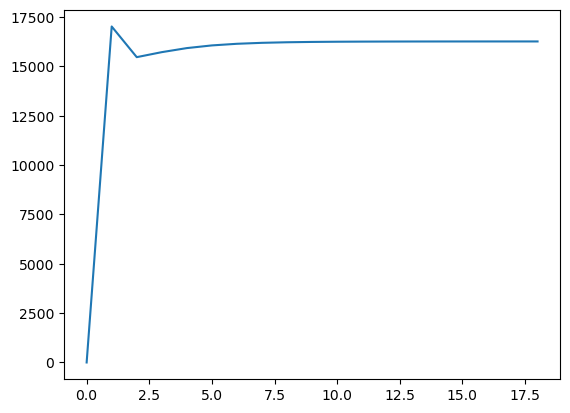

In [6]:
plt.plot(blame_all_costs_agent2)

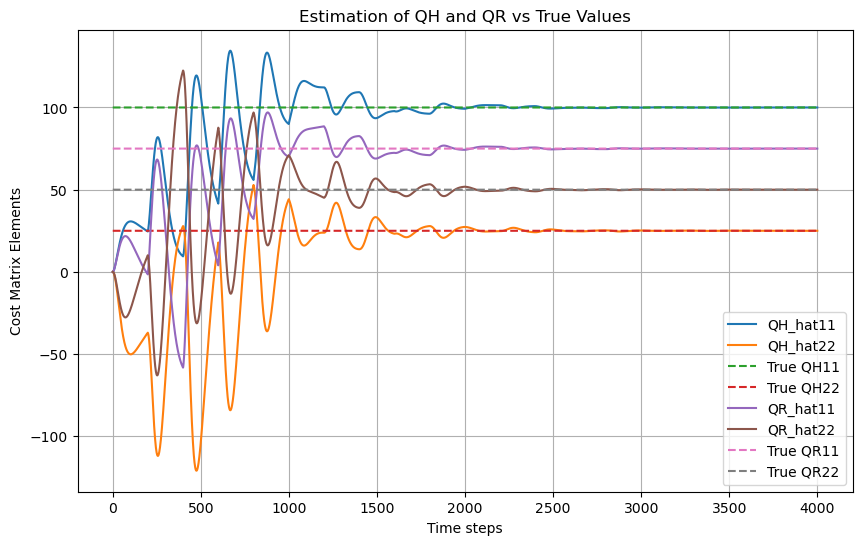

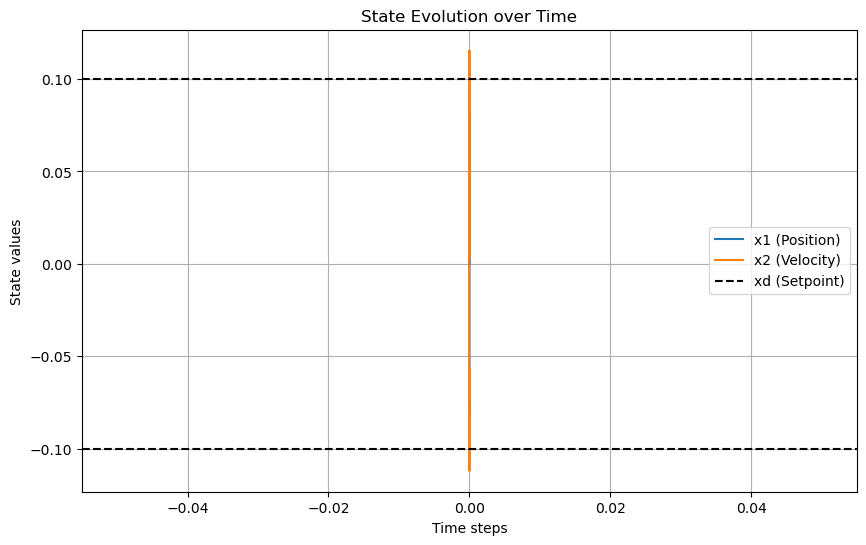

In [6]:
import numpy as np
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt

# Parameters
n_step = 4000
T = 0.01
n_iteration = 2  # Adjust as needed

# Initial cost function weights
Qsum = np.array([[100, 0], [0, 25]])
lambda_ = 1
QR = np.array([[75, 0], [0, 50]])
QH_hat = np.zeros((2, 2))

# Initial gain
LR = np.zeros((1, 2))
LH_hat = np.zeros((1, 2))
LR_hat = np.zeros((1, 2))
PH_hat = np.zeros((2, 2))
PR_hat = np.zeros((2, 2))

xd = 0.1
uR = 0
uH = 0

# Data storage arrays
x1 = np.zeros((n_step, n_iteration))
xd1 = np.zeros((n_step, n_iteration))
dot_x1 = np.zeros((n_step, n_iteration))
QH11 = np.zeros((n_step, n_iteration))
QH22 = np.zeros((n_step, n_iteration))
QH_hat11 = np.zeros((n_step, n_iteration))
QH_hat22 = np.zeros((n_step, n_iteration))
QR11 = np.zeros((n_step, n_iteration))
QR22 = np.zeros((n_step, n_iteration))
QR_hat11 = np.zeros((n_step, n_iteration))
QR_hat22 = np.zeros((n_step, n_iteration))

# More storage for gains and other variables
LR1 = np.zeros((n_step, n_iteration))
LR2 = np.zeros((n_step, n_iteration))
LH1 = np.zeros((n_step, n_iteration))
LH2 = np.zeros((n_step, n_iteration))
LR_hat1 = np.zeros((n_step, n_iteration))
LR_hat2 = np.zeros((n_step, n_iteration))
LH_hat1 = np.zeros((n_step, n_iteration))
LH_hat2 = np.zeros((n_step, n_iteration))
xi_hat1 = np.zeros((n_step, n_iteration))
xi_hat2 = np.zeros((n_step, n_iteration))
xi1 = np.zeros((n_step, n_iteration))
xi2 = np.zeros((n_step, n_iteration))
t1 = np.zeros(n_step)

a_values = [10]  # Keep as [10]

for a in a_values:
    for j in range(n_iteration):
        # Initial states
        x = 0
        dot_x = 0
        e = 0
        xi = np.array([e, dot_x])
        xi_hat = xi.copy()
        xi_hatH = xi.copy()

        for i in range(n_step):
            t = i * T

            if i % 200 == 0 and i != 0:
                xd = -xd

            # Robot dynamics
            M = 6
            C = -0.2

            # State
            e = x - xd
            xi = np.array([e, dot_x])

            # System matrices
            A = np.array([[0, 1], [0, -C / M]])
            B = np.array([[0], [1 / M]])  # Shape (2,1)

            # Human's cost function
            QH = 0.1 * a * Qsum  # Active line

            # Human controller
            AH_hat = A - B @ (LR_hat + 0 * np.array([[0, 50]]))  # +1 * [0, 50] to simulate biased estimation
            PH = solve_continuous_are(AH_hat, B, QH, np.array([[1]]))
            LH = (B.T @ PH).flatten()  # Shape (2,)
            uH = -np.dot(LH, xi)

            # Robot controller
            AR_hat = A - B @ (LH_hat + 0 * np.array([[0, 50]]))  # +1 * [0, 50] to simulate biased estimation
            PR = solve_continuous_are(AR_hat, B, QR, np.array([[1]]))
            LR = (B.T @ PR).flatten()  # Shape (2,)
            uR = -np.dot(LR, xi)

            # Update observers and estimated cost functions
            Gamma = np.array([[10, 0], [0, 1]])
            uH_hat = -np.dot(LH_hat.flatten(), xi)
            xi_tilde = xi_hat - xi
            xi_hat = xi_hat + T * (A @ xi_hat + B.flatten() * uR + B.flatten() * uH_hat - Gamma @ xi_tilde)

            # Update estimated cost function for robot
            alpha = np.array([[0, 0], [0, 10000]])
            A_RH_hat = A - B @ LH_hat - B @ LR.reshape(1, 2)
            PH_hat = PH_hat + T * alpha @ np.outer(xi_tilde, xi)
            PH_hat[0, 1] = PH_hat[1, 0]  # Ensure symmetry
            LH_hat = (B.T @ PH_hat).reshape(1, 2)  # Shape (1,2)

            # Update estimated human cost function
            AH = A - B @ LR.reshape(1, 2)
            QH_hat = -(AH.T @ PH_hat + PH_hat @ AH - PH_hat @ B @ B.T @ PH_hat)
            QH_hat[0, 1] = 0
            QH_hat[1, 0] = 0

            # Update human observer
            GammaH = np.array([[10, 0], [0, 1]])
            uR_hat = -np.dot(LR_hat.flatten(), xi)
            xi_tildeH = xi_hatH - xi
            xi_hatH = xi_hatH + T * (A @ xi_hatH + B.flatten() * uR_hat + B.flatten() * uH - GammaH @ xi_tildeH)

            # Update robot's estimation of its own cost function
            alphaH = np.array([[0, 0], [0, 10000]])
            A_HR_hat = A - B @ LH.reshape(1, 2) - B @ LR_hat
            PR_hat = PR_hat + T * alphaH @ np.outer(xi_tildeH, xi)
            PR_hat[0, 1] = PR_hat[1, 0]
            LR_hat = (B.T @ PR_hat).reshape(1, 2)  # Shape (1,2)

            # Update cost function for robot's estimation
            AR = A - B @ LH.reshape(1, 2)
            QR_hat = -(AR.T @ PR_hat + PR_hat @ AR - PR_hat @ B @ B.T @ PR_hat)
            QR_hat[0, 1] = 0
            QR_hat[1, 0] = 0

            # State update
            xi = xi + T * (A @ xi + B.flatten() * uR + B.flatten() * uH)
            x = xi[0] + xd
            dot_x = xi[1]

            # Data collection
            x1[i, j] = x
            xd1[i, j] = xd
            dot_x1[i, j] = dot_x
            QH11[i, j] = QH[0, 0]
            QH22[i, j] = QH[1, 1]
            QH_hat11[i, j] = QH_hat[0, 0]
            QH_hat22[i, j] = QH_hat[1, 1]
            QR11[i, j] = QR[0, 0]
            QR22[i, j] = QR[1, 1]
            QR_hat11[i, j] = QR_hat[0, 0]
            QR_hat22[i, j] = QR_hat[1, 1]

# Plotting the estimation of QH and QR
plt.figure(figsize=(10, 6))
plt.plot(QH_hat11[:, 0], label='QH_hat11')
plt.plot(QH_hat22[:, 0], label='QH_hat22')
plt.plot(QH11[:, 0], '--', label='True QH11')
plt.plot(QH22[:, 0], '--', label='True QH22')
plt.plot(QR_hat11[:, 0], label='QR_hat11')
plt.plot(QR_hat22[:, 0], label='QR_hat22')
plt.plot(QR11[:, 0], '--', label='True QR11')
plt.plot(QR22[:, 0], '--', label='True QR22')
plt.legend()
plt.title("Estimation of QH and QR vs True Values")
plt.xlabel("Time steps")
plt.ylabel("Cost Matrix Elements")
plt.grid(True)
plt.show()

# Plotting x (state) over time
plt.figure(figsize=(10, 6))
plt.plot(t1, x1[:, 0], label='x1 (Position)')
plt.plot(t1, dot_x1[:, 0], label='x2 (Velocity)')
plt.axhline(y=0.1, color='k', linestyle='--', label='xd (Setpoint)')
plt.axhline(y=-0.1, color='k', linestyle='--')
plt.legend()
plt.title("State Evolution over Time")
plt.xlabel("Time steps")
plt.ylabel("State values")
plt.grid(True)
plt.show()



In [27]:
import pandas as pd
import numpy as np

# True values for each theta
true_values = {
    "theta_h1": 100,
    "theta_h2": 25,
    "theta_r1": 75,
    "theta_r2": 50
}

# Function to find the first time when all subsequent errors are below 10% of the true value
def find_time_below_10_percent(estimation, true_value, time_step=0.01):
    threshold = 0.1 * true_value
    for sample in range(len(estimation)):
        if all(abs(estimation[i] - true_value) < threshold for i in range(sample, len(estimation))):
            return sample * time_step
    return None

# Function to calculate error percentage at the last point
def calculate_error_percentage(estimation, true_value):
    last_error = abs(estimation[-1] - true_value)
    return (last_error / true_value) * 100

# Function to calculate standard deviation of the error percentage over the entire estimation series
def calculate_error_std(estimation, true_value):
    error_percentages = [(abs(est - true_value) / true_value) * 100 for est in estimation]
    return np.std(error_percentages)

# Organizing the data
data = {
    ("Blame-me", "std"): [
        calculate_error_std(Q2_diag_0_history_me, true_values["theta_h1"]),
        calculate_error_std(Q2_diag_1_history_me, true_values["theta_h2"]),
        calculate_error_std(Q1_diag_0_history_me, true_values["theta_r1"]),
        calculate_error_std(Q1_diag_1_history_me, true_values["theta_r2"])
    ],
    ("Blame-me", "time < 10% error"): [
        find_time_below_10_percent(Q2_diag_0_history_me, true_values["theta_h1"]),
        find_time_below_10_percent(Q2_diag_1_history_me, true_values["theta_h2"]),
        find_time_below_10_percent(Q1_diag_0_history_me, true_values["theta_r1"]),
        find_time_below_10_percent(Q1_diag_1_history_me, true_values["theta_r2"])
    ],
    ("Blame-me", "error % at last"): [
        calculate_error_percentage(Q2_diag_0_history_me, true_values["theta_h1"]),
        calculate_error_percentage(Q2_diag_1_history_me, true_values["theta_h2"]),
        calculate_error_percentage(Q1_diag_0_history_me, true_values["theta_r1"]),
        calculate_error_percentage(Q1_diag_1_history_me, true_values["theta_r2"])
    ],
    ("Blame-all", "std"): [
        calculate_error_std(Q2_diag_0_history_all, true_values["theta_h1"]),
        calculate_error_std(Q2_diag_1_history_all, true_values["theta_h2"]),
        calculate_error_std(Q1_diag_0_history_all, true_values["theta_r1"]),
        calculate_error_std(Q1_diag_1_history_all, true_values["theta_r2"])
    ],
    ("Blame-all", "time < 10% error"): [
        find_time_below_10_percent(Q2_diag_0_history_all, true_values["theta_h1"]),
        find_time_below_10_percent(Q2_diag_1_history_all, true_values["theta_h2"]),
        find_time_below_10_percent(Q1_diag_0_history_all, true_values["theta_r1"]),
        find_time_below_10_percent(Q1_diag_1_history_all, true_values["theta_r2"])
    ],
    ("Blame-all", "error % at last"): [
        calculate_error_percentage(Q2_diag_0_history_all, true_values["theta_h1"]),
        calculate_error_percentage(Q2_diag_1_history_all, true_values["theta_h2"]),
        calculate_error_percentage(Q1_diag_0_history_all, true_values["theta_r1"]),
        calculate_error_percentage(Q1_diag_1_history_all, true_values["theta_r2"])
    ],
    ("Baseline", "std"): [
        calculate_error_std(QH_hat11[:, 0], true_values["theta_h1"]),
        calculate_error_std(QH_hat22[:, 0], true_values["theta_h2"]),
        calculate_error_std(QR_hat11[:, 0], true_values["theta_r1"]),
        calculate_error_std(QR_hat22[:, 0], true_values["theta_r2"])
    ],
    ("Baseline", "time < 10% error"): [
        find_time_below_10_percent(QH_hat11[:, 0], true_values["theta_h1"]),
        find_time_below_10_percent(QH_hat22[:, 0], true_values["theta_h2"]),
        find_time_below_10_percent(QR_hat11[:, 0], true_values["theta_r1"]),
        find_time_below_10_percent(QR_hat22[:, 0], true_values["theta_r2"])
    ],
    ("Baseline", "error % at last"): [
        calculate_error_percentage(QH_hat11[:, 0], true_values["theta_h1"]),
        calculate_error_percentage(QH_hat22[:, 0], true_values["theta_h2"]),
        calculate_error_percentage(QR_hat11[:, 0], true_values["theta_r1"]),
        calculate_error_percentage(QR_hat22[:, 0], true_values["theta_r2"])
    ]
}

# Convert to a DataFrame and set the index as the theta parameters
index = ["theta_h1", "theta_h2", "theta_r1", "theta_r2"]
df = pd.DataFrame(data, index=index)

# Display the DataFrame
print(df)


           Blame-me                                   Blame-all  \
                std time < 10% error error % at last        std   
theta_h1  23.668596             6.19        0.000393  22.741400   
theta_h2  25.726637             9.29        0.002158  26.893211   
theta_r1  25.689537             8.14        0.000961  23.946844   
theta_r2  24.517740             7.08        0.000825  25.861645   

                                             Baseline                   \
         time < 10% error error % at last         std time < 10% error   
theta_h1             4.28        0.000007   22.346739            12.14   
theta_h2             7.11        0.000045  126.335483            19.09   
theta_r1             6.20        0.000020   32.276264            14.02   
theta_r2             6.73        0.000015   45.930133            15.18   

                          
         error % at last  
theta_h1        0.008092  
theta_h2        0.075514  
theta_r1        0.008962  
theta_r2        0

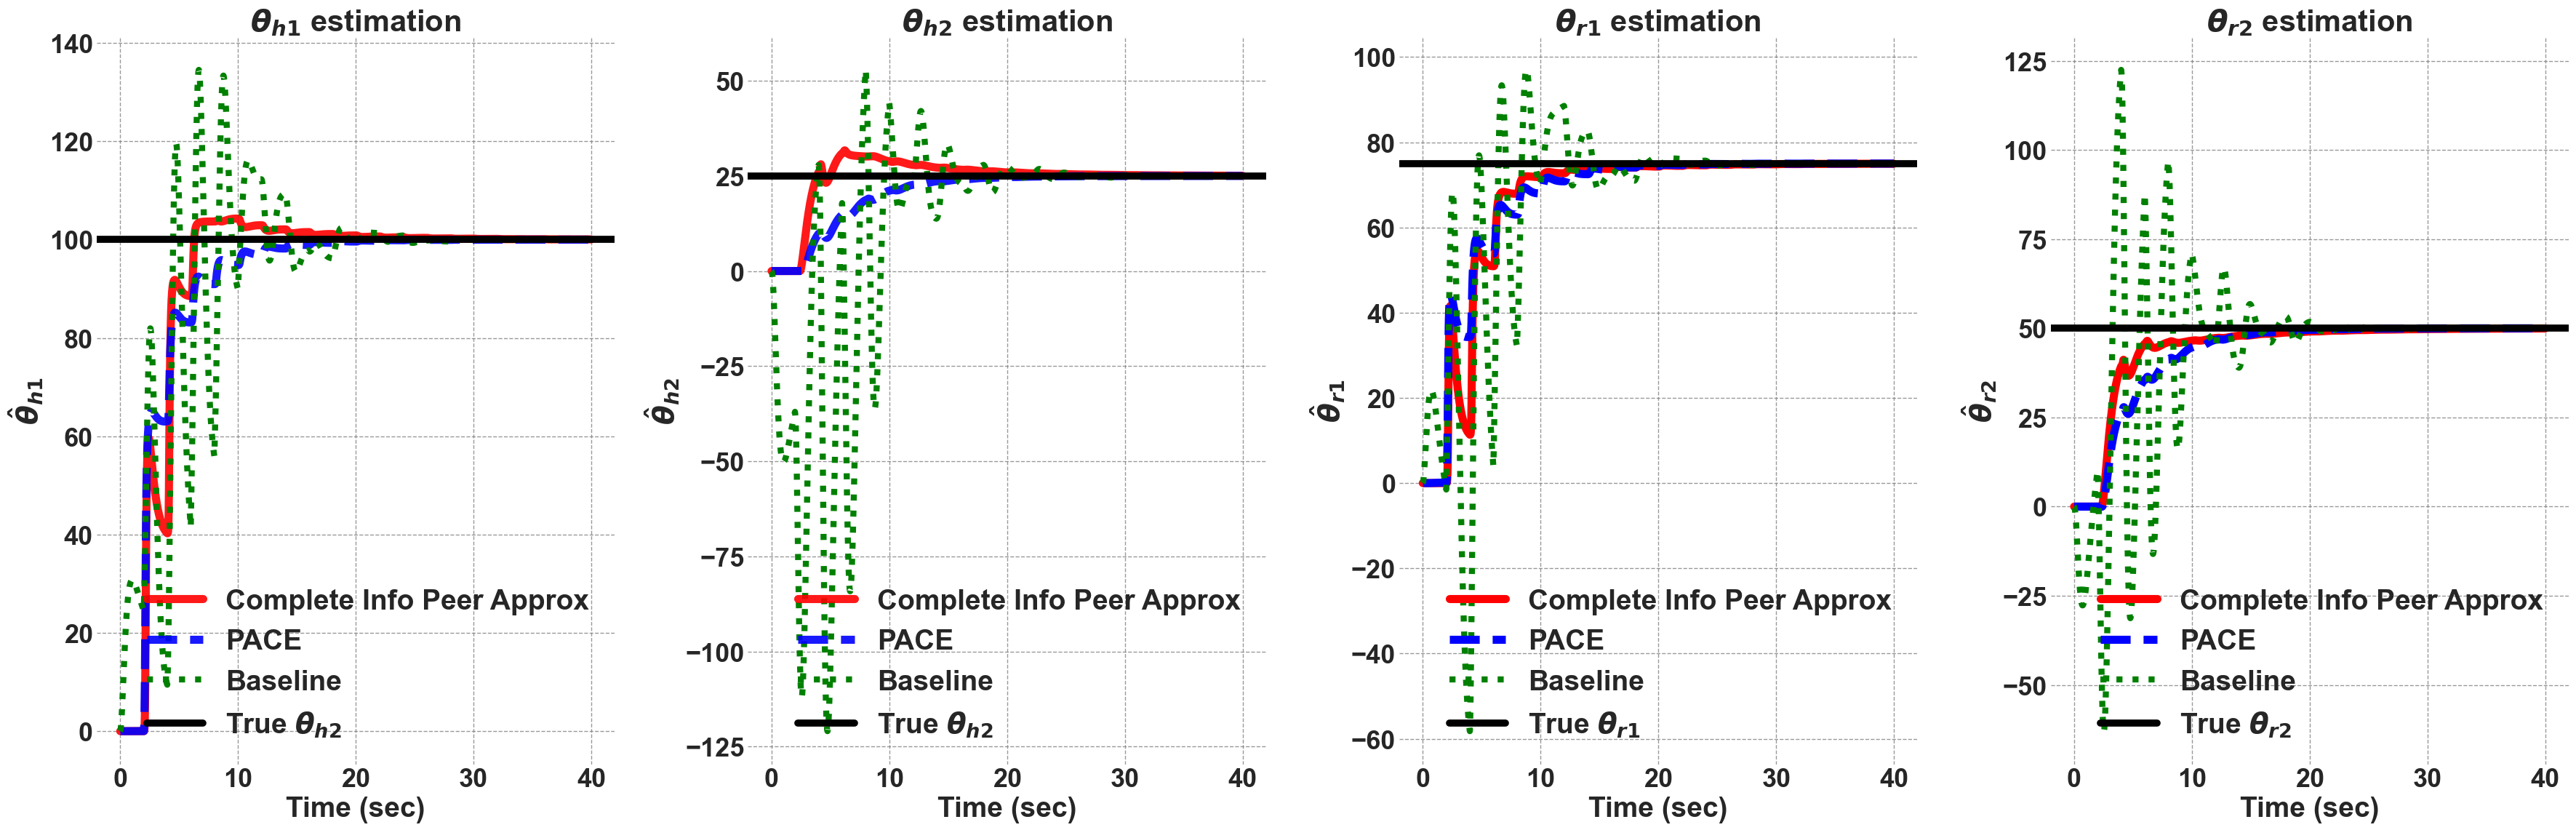

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming each estimation array has the same length, calculate the time vector
sampling_time = 0.01  # Sampling time in seconds
num_samples = len(Q2_diag_0_history_me)  # Assuming all arrays have the same length
time_vector = np.arange(0, num_samples * sampling_time, sampling_time)

# Reset to default style with a white background and bold font
plt.rcParams.update({'axes.facecolor': 'white', 'font.size': 26, 'font.weight': 'bold'})  # White background, bold font

# Create the figure with 1 row and 4 columns, increasing width for better visibility
fig, axes = plt.subplots(1, 4, figsize=(36, 12))  # Wider figure for better space utilization

# First plot: Q2_diag_0_history_me, Q2_diag_0_history_all, QH_hat11, and its true value
axes[0].plot(time_vector, Q2_diag_0_history_me, 'r-', linewidth=8, label='Complete Info Peer Approx', alpha=0.9)
axes[0].plot(time_vector, Q2_diag_0_history_all, 'b--', linewidth=8, label='PACE', alpha=0.9)
axes[0].plot(time_vector, QH_hat11[:, 0], 'g:', linewidth=6, label='Baseline')
axes[0].axhline(y=100, color='k', linestyle='-', linewidth=7, label=r'True $\theta_{h2}$')
axes[0].set_title(r'$\theta_{h1}$ estimation', fontsize=30, fontweight='bold')
axes[0].set_xlabel('Time (sec)', fontsize=28, fontweight='bold')
axes[0].set_ylabel(r'$\hat{\theta}_{h1}$', fontsize=28, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=28, frameon=False)
axes[0].grid(visible=True, which='both', color='gray', linestyle='--', linewidth=1, alpha=0.8)

# Second plot: Q2_diag_1_history_me, Q2_diag_1_history_all, QH_hat22, and its true value
axes[1].plot(time_vector, Q2_diag_1_history_me, 'r-', linewidth=8, label='Complete Info Peer Approx', alpha=0.9)
axes[1].plot(time_vector, Q2_diag_1_history_all, 'b--', linewidth=8, label='PACE', alpha=0.9)
axes[1].plot(time_vector, QH_hat22[:, 0], 'g:', linewidth=6, label='Baseline')
axes[1].axhline(y=25, color='k', linestyle='-', linewidth=7, label=r'True $\theta_{h2}$')
axes[1].set_title(r'$\theta_{h2}$ estimation', fontsize=30, fontweight='bold')
axes[1].set_xlabel('Time (sec)', fontsize=28, fontweight='bold')
axes[1].set_ylabel(r'$\hat{\theta}_{h2}$', fontsize=28, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=28, frameon=False)
axes[1].grid(visible=True, which='both', color='gray', linestyle='--', linewidth=1, alpha=0.8)

# Third plot: Q1_diag_0_history_me, Q1_diag_0_history_all, QR_hat11, and its true value
axes[2].plot(time_vector, Q1_diag_0_history_me, 'r-', linewidth=8, label='Complete Info Peer Approx')
axes[2].plot(time_vector, Q1_diag_0_history_all, 'b--', linewidth=8, label='PACE')
axes[2].plot(time_vector, QR_hat11[:, 0], 'g:', linewidth=6, label=r'Baseline')
axes[2].axhline(y=75, color='k', linestyle='-', linewidth=7, label=r'True $\theta_{r1}$')
axes[2].set_title(r'$\theta_{r1}$ estimation', fontsize=30, fontweight='bold')
axes[2].set_xlabel('Time (sec)', fontsize=28, fontweight='bold')
axes[2].set_ylabel(r'$\hat{\theta}_{r1}$', fontsize=28, fontweight='bold')
axes[2].legend(loc='lower right', fontsize=28, frameon=False)
axes[2].grid(visible=True, which='both', color='gray', linestyle='--', linewidth=1, alpha=0.8)

# Fourth plot: Q1_diag_1_history_me, Q1_diag_1_history_all, QR_hat22, and its true value
axes[3].plot(time_vector, Q1_diag_1_history_me, 'r-', linewidth=8, label='Complete Info Peer Approx')
axes[3].plot(time_vector, Q1_diag_1_history_all, 'b--', linewidth=8, label='PACE')
axes[3].plot(time_vector, QR_hat22[:, 0], 'g:', linewidth=6, label=r'Baseline')
axes[3].axhline(y=50, color='k', linestyle='-', linewidth=7, label=r'True $\theta_{r2}$')
axes[3].set_title(r'$\theta_{r2}$ estimation', fontsize=30, fontweight='bold')
axes[3].set_xlabel('Time (sec)', fontsize=28, fontweight='bold')
axes[3].set_ylabel(r'$\hat{\theta}_{r2}$', fontsize=28, fontweight='bold')
axes[3].legend(loc='lower right',fontsize=28, frameon=False)
axes[3].grid(visible=True, which='both', color='gray', linestyle='--', linewidth=1, alpha=0.8)

# Adjust layout for the whole figure to reduce overlap and improve readability
plt.tight_layout()

# Save the figure as a high-resolution PNG file
plt.savefig("exp2_comparison_plot_time_axis.png", dpi=300)

# Show the plot
plt.show()
